In [1]:
import os
import math
import pickle
from collections import defaultdict

import wandb
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.interpolate import interp1d

In [2]:
metric_names = ["world_knowledge", "commonsense_reasoning", "language_understanding", "symbolic_problem_solving", "reading_comprehension", "average"]
raw_metric_names = [os.path.join("icl", "metrics", "raw_eval_gauntlet", cat) for cat in metric_names]
normalized_metric_names = [os.path.join("icl", "metrics", "eval_gauntlet", cat) for cat in metric_names]
metrics_to_fetch = raw_metric_names + normalized_metric_names

# Downloading results from WanDB

In [3]:
# Defining the groups to fetch
groups = {
    "pile-1b": [
        "pile-passes-0.25-final-1B-26B-baseline",
        "pile-passes-0.25-final-1B-26B-offline-global-easy-0.5-ref-125M-26B",
        "pile-passes-0.25-final-1B-26B-offline-global-mid-0.5-ref-125M-26B",
        "pile-passes-0.25-final-1B-26B-offline-global-hard-0.5-ref-125M-26B",
    ],
    "mpt-1b": [
        "mpt-passes-0.25-final-1B-26B-baseline",
        "mpt-passes-0.25-final-1B-26B-offline-global-easy-0.5-ref-125M-26B",
        "mpt-passes-0.25-final-1B-26B-offline-global-mid-0.5-ref-125M-26B",
        "mpt-passes-0.25-final-1B-26B-offline-global-hard-0.5-ref-125M-26B",
    ],
    "dolma-1b": [
        "dolma-passes-0.25-final-1B-26B-baseline",
        "dolma-passes-0.25-final-1B-26B-offline-global-easy-0.5-ref-125M-26B",
        "dolma-passes-0.25-final-1B-26B-offline-global-mid-0.5-ref-125M-26B",
        "dolma-passes-0.25-final-1B-26B-offline-global-hard-0.5-ref-125M-26B",
    ],
    "selection-rate-pile-1b": [
        "pile-passes-0.25-final-1B-26B-offline-global-hard-0.25-ref-125M-26B",
        "pile-passes-0.25-final-1B-26B-offline-global-hard-0.5-ref-125M-26B",
        "pile-passes-0.25-final-1B-26B-offline-global-hard-0.75-ref-125M-26B",
    ],
    "selection-rate-mpt-1b": [
        "mpt-passes-0.25-final-1B-26B-offline-global-mid-0.25-ref-125M-26B",
        "mpt-passes-0.25-final-1B-26B-offline-global-mid-0.5-ref-125M-26B",
        "mpt-passes-0.25-final-1B-26B-offline-global-mid-0.75-ref-125M-26B",
    ],
    "selection-rate-dolma-1b": [
        "dolma-passes-0.25-final-1B-26B-offline-global-mid-0.25-ref-125M-26B",
        "dolma-passes-0.25-final-1B-26B-offline-global-mid-0.5-ref-125M-26B",
        "dolma-passes-0.25-final-1B-26B-offline-global-mid-0.75-ref-125M-26B",
    ],
    "pile-3b": [
        "pile-passes-0.5-final-3B-52B-baseline",
        "pile-passes-0.5-final-3B-52B-offline-global-hard-0.5-ref-125M-26B",
    ],
    "mpt-3b": [
        "mpt-passes-0.5-final-3B-52B-baseline",
        "mpt-passes-0.5-final-3B-52B-offline-global-mid-0.5-ref-125M-26B",
    ],
    "dolma-3b": [
        "dolma-passes-0.5-final-3B-52B-baseline",
        "dolma-passes-0.5-final-3B-52B-offline-global-mid-0.5-ref-125M-26B",
    ],
    "pile-5x-tokens": [
        "pile-passes-0.5-final-1B-130B-baseline",
        "pile-passes-0.5-final-1B-130B-offline-global-hard-0.5-ref-125M-26B",
    ],
    "dolma-5x-tokens": [
        "dolma-passes-0.5-final-1B-130B-baseline",
        "dolma-passes-0.5-final-1B-130B-offline-global-mid-0.5-ref-125M-26B",
    ],
    "pile-repeats": [
        "pile-passes-0.25-final-1B-26B-baseline",
        "pile-passes-0.25-final-1B-26B-baseline",
        "pile-passes-2.0-final-1B-26B-baseline",
        "pile-passes-4.0-final-1B-26B-baseline",
        "pile-passes-8.0-final-1B-26B-baseline",
        "pile-passes-0.25-final-1B-26B-offline-global-hard-0.5-ref-125M-26B",
        "pile-passes-1.0-final-1B-26B-offline-global-hard-0.5-ref-125M-26B",
        "pile-passes-2.0-final-1B-26B-offline-global-hard-0.5-ref-125M-26B",
        "pile-passes-4.0-final-1B-26B-offline-global-hard-0.5-ref-125M-26B",
        "pile-passes-8.0-final-1B-26B-offline-global-hard-0.5-ref-125M-26B",
    ],
    "dolma-repeats": [
        "dolma-passes-0.25-final-1B-26B-baseline",
        "dolma-passes-0.25-final-1B-26B-baseline",
        "dolma-passes-2.0-final-1B-26B-baseline",
        "dolma-passes-4.0-final-1B-26B-baseline",
        "dolma-passes-8.0-final-1B-26B-baseline",
        "dolma-passes-0.25-final-1B-26B-offline-global-mid-0.5-ref-125M-26B",
        "dolma-passes-1.0-final-1B-26B-offline-global-mid-0.5-ref-125M-26B",
        "dolma-passes-2.0-final-1B-26B-offline-global-mid-0.5-ref-125M-26B",
        "dolma-passes-4.0-final-1B-26B-offline-global-mid-0.5-ref-125M-26B",
        "dolma-passes-8.0-final-1B-26B-offline-global-mid-0.5-ref-125M-26B",
    ],
    "mpt-repeats": [
        "mpt-passes-0.25-final-1B-26B-baseline",
        "mpt-passes-0.25-final-1B-26B-baseline",
        "mpt-passes-2.0-final-1B-26B-baseline",
        "mpt-passes-4.0-final-1B-26B-baseline",
        "mpt-passes-8.0-final-1B-26B-baseline",
        "mpt-passes-0.25-final-1B-26B-offline-global-mid-0.5-ref-125M-26B",
        "mpt-passes-1.0-final-1B-26B-offline-global-mid-0.5-ref-125M-26B",
        "mpt-passes-2.0-final-1B-26B-offline-global-mid-0.5-ref-125M-26B",
        "mpt-passes-4.0-final-1B-26B-offline-global-mid-0.5-ref-125M-26B",
        "mpt-passes-8.0-final-1B-26B-offline-global-mid-0.5-ref-125M-26B",
    ],
}

In [4]:
seq_len = 2048
batch_size = 512
def fetch_results(group_to_fetch):
    api = wandb.Api()
    project_name = "mosaic-ml/me-fomo-data-filtering"

    runs = api.runs(project_name)

    grouped_raw_results = {group: defaultdict(list) for group in groups[group_to_fetch]}

    for run in tqdm(runs):
        group = run.group.replace("eval-", "")

        if group not in groups[group_to_fetch]:
            continue
        if "ignore" in run.tags:
            continue
        if "eval" not in run.tags:
            continue
        if run.state != "finished":
            continue

        history = run.scan_history(keys=metrics_to_fetch + ["_step"])
        for row in history:
            token_step = seq_len * batch_size * row["_step"]
            token_step = round(token_step / 1e9, 1)
            raw_metrics = [row[metric_name] for metric_name in raw_metric_names]
            normalized_metrics = [row[metric_name] for metric_name in normalized_metric_names]
            grouped_raw_results[group][token_step].append({
                "raw_metrics": raw_metrics,
                "normalized_metrics": normalized_metrics,
            })
    
    return grouped_raw_results

In [5]:
def process_raw_results(grouped_raw_results):
    grouped_processed_results = {group: defaultdict(dict) for group in grouped_raw_results.keys()}
    for group, step_wise_results in grouped_raw_results.items():
        for step, all_results in step_wise_results.items():
            all_raw = [res["raw_metrics"] for res in all_results]
            all_normalized = [res["normalized_metrics"] for res in all_results]
            for metric_type, results in zip(["raw_metrics", "normalized_metrics"], [all_raw, all_normalized]):
                avg_results = np.mean(results, axis=0)
                ste_results = np.std(results, axis=0) / np.sqrt(len(results))
                results_dict = {"avgs": avg_results, "stes": ste_results, "n_res": len(results)}
                grouped_processed_results[group][step][metric_type] = results_dict
    return grouped_processed_results

### Querrying each group

In [125]:
pile_1b_grouped_raw_results = fetch_results("pile-1b")
pile_1b_processed_results = process_raw_results(pile_1b_grouped_raw_results)
with open("data/evals/pile_1b_processed_results.pkl", "wb") as f:
    pickle.dump(pile_1b_processed_results, f)

 57%|█████▋    | 650/1133 [00:03<00:02, 189.94it/s]


KeyboardInterrupt: 

In [ ]:
mpt_1b_grouped_raw_results = fetch_results("mpt-1b")
mpt_1b_processed_results = process_raw_results(mpt_1b_grouped_raw_results)
with open("data/evals/mpt_1b_processed_results.pkl", "wb") as f:
    pickle.dump(mpt_1b_processed_results, f)

100%|██████████| 951/951 [05:28<00:00,  2.89it/s] 


In [ ]:
dolma_1b_grouped_raw_results = fetch_results("dolma-1b")
dolma_1b_processed_results = process_raw_results(dolma_1b_grouped_raw_results)
with open("data/evals/dolma_1b_processed_results.pkl", "wb") as f:
    pickle.dump(dolma_1b_processed_results, f)

100%|██████████| 951/951 [03:44<00:00,  4.23it/s] 


In [ ]:
selection_rate_pile_1b_grouped_raw_results = fetch_results("selection-rate-pile-1b")
selection_rate_pile_1b_processed_results = process_raw_results(selection_rate_pile_1b_grouped_raw_results)
with open("data/evals/selection_rate_pile_1b_processed_results.pkl", "wb") as f:
    pickle.dump(selection_rate_pile_1b_processed_results, f)

100%|██████████| 951/951 [01:49<00:00,  8.65it/s] 


In [ ]:
selection_rate_mpt_1b_grouped_raw_results = fetch_results("selection-rate-mpt-1b")
selection_rate_mpt_1b_processed_results = process_raw_results(selection_rate_mpt_1b_grouped_raw_results)
with open("data/evals/selection_rate_mpt_1b_processed_results.pkl", "wb") as f:
    pickle.dump(selection_rate_mpt_1b_processed_results, f)

100%|██████████| 951/951 [01:39<00:00,  9.57it/s] 


In [ ]:
selection_rate_dolma_1b_grouped_raw_results = fetch_results("selection-rate-dolma-1b")
selection_rate_dolma_1b_processed_results = process_raw_results(selection_rate_dolma_1b_grouped_raw_results)
with open("data/evals/selection_rate_dolma_1b_processed_results.pkl", "wb") as f:
    pickle.dump(selection_rate_dolma_1b_processed_results, f)

100%|██████████| 951/951 [01:17<00:00, 12.29it/s] 


In [ ]:
pile_3b_grouped_raw_results = fetch_results("pile-3b")
pile_3b_processed_results = process_raw_results(pile_3b_grouped_raw_results)
with open("data/evals/pile_3b_processed_results.pkl", "wb") as f:
    pickle.dump(pile_3b_processed_results, f)

100%|██████████| 951/951 [05:53<00:00,  2.69it/s] 


In [ ]:
mpt_3b_grouped_raw_results = fetch_results("mpt-3b")
mpt_3b_processed_results = process_raw_results(mpt_3b_grouped_raw_results)
with open("data/evals/mpt_3b_processed_results.pkl", "wb") as f:
    pickle.dump(mpt_3b_processed_results, f)

100%|██████████| 951/951 [06:35<00:00,  2.41it/s]  


In [ ]:
dolma_3b_grouped_raw_results = fetch_results("dolma-3b")
dolma_3b_processed_results = process_raw_results(dolma_3b_grouped_raw_results)
with open("data/evals/dolma_3b_processed_results.pkl", "wb") as f:
    pickle.dump(dolma_3b_processed_results, f)

100%|██████████| 951/951 [05:57<00:00,  2.66it/s]  


In [ ]:
pile_5x_tokens_grouped_raw_results = fetch_results("pile-5x-tokens")
pile_5x_tokens_processed_results = process_raw_results(pile_5x_tokens_grouped_raw_results)
with open("data/evals/pile_5x_tokens_processed_results.pkl", "wb") as f:
    pickle.dump(pile_5x_tokens_processed_results, f)

100%|██████████| 951/951 [02:35<00:00,  6.13it/s] 


In [ ]:
dolma_5x_tokens_grouped_raw_results = fetch_results("dolma-5x-tokens")
dolma_5x_tokens_processed_results = process_raw_results(dolma_5x_tokens_grouped_raw_results)
with open("data/evals/dolma_5x_tokens_processed_results.pkl", "wb") as f:
    pickle.dump(dolma_5x_tokens_processed_results, f)

100%|██████████| 951/951 [01:53<00:00,  8.36it/s] 


In [129]:
pile_repeats_grouped_raw_results = fetch_results("pile-repeats")
pile_repeats_processed_results = process_raw_results(pile_repeats_grouped_raw_results)
with open("data/evals/pile_repeats_processed_results.pkl", "wb") as f:
    pickle.dump(pile_repeats_processed_results, f)

100%|██████████| 1133/1133 [02:44<00:00,  6.87it/s]


In [130]:
mpt_repeats_grouped_raw_results = fetch_results("mpt-repeats")
mpt_repeats_processed_results = process_raw_results(mpt_repeats_grouped_raw_results)
with open("data/evals/mpt_repeats_processed_results.pkl", "wb") as f:
    pickle.dump(mpt_repeats_processed_results, f)

100%|██████████| 1133/1133 [03:32<00:00,  5.33it/s]


In [131]:
dolma_repeats_grouped_raw_results = fetch_results("dolma-repeats")
dolma_repeats_processed_results = process_raw_results(dolma_repeats_grouped_raw_results)
with open("data/evals/dolma_repeats_processed_results.pkl", "wb") as f:
    pickle.dump(dolma_repeats_processed_results, f)

100%|██████████| 1133/1133 [03:06<00:00,  6.07it/s] 


# Preparing results for the paper

In [4]:
def plot_all_results(group_processed_results, raw=False, save_name=""):
    # Calculate the number of rows needed for the subplots
    rows = math.ceil((len(metric_names)) / 3)

    fig, axs = plt.subplots(rows, 3, figsize=(20, 5*rows))  # Create a grid of subplots

    # Flatten the axs array for easy iteration
    axs = axs.flatten()

    # Iterate over each category (metric)
    for i, category in enumerate(metric_names):
    
        # Iterate over each run
        for group_name, step_metrics in group_processed_results.items():
            if len(step_metrics) < 2:
                continue
            steps = sorted(step_metrics.keys())
        
            # Get the metric values for the current category
            key = "raw_metrics" if raw else "normalized_metrics"
            avg_metrics = [step_metrics[step][key]["avgs"][i] for step in steps]
            ste_metrics = [step_metrics[step][key]["stes"][i] for step in steps]
        
            axs[i].plot(steps, avg_metrics, label=group_name)
            axs[i].fill_between(steps, np.array(avg_metrics) - np.array(ste_metrics), np.array(avg_metrics) + np.array(ste_metrics), alpha=0.3)
        
        axs[i].legend(loc="lower right")
        axs[i].set_ylabel(f"{category} Score")
        axs[i].set_xlabel("Tokens (Billion)")
        axs[i].set_title(f"{category}")

    # Remove any unused subplots
    for i in range(len(metric_names), len(axs)):
        fig.delaxes(axs[i])

    plt.tight_layout()

    # Save the figure to disk
    if save_name:
        plt.savefig(save_name)

    plt.show()

In [5]:
def print_tex_table(grouped_processed_results, step, raw=False ,show_best=True):
    for key in ["raw_metrics", "normalized_metrics"]:
        print("=" * 30)
        print(key.upper())
        print("=" * 30)
        max_ste_adjusted = []
        for metric_idx in range(len(metric_names)):
            cur_best_acc = 0
            cur_best_ste = 0
            for group_name, all_step_metrics in grouped_processed_results.items():
                step_metrics = all_step_metrics[step]
                # if raw:
                #     step_metrics = step_metrics["raw_metrics"]
                # else:
                #     step_metrics = step_metrics["normalized_metrics"]
                step_metrics = step_metrics[key]
                avg_metric = round(100 * step_metrics["avgs"][metric_idx], 2)
                ste_metric = round(100 * step_metrics["stes"][metric_idx], 2)
                if avg_metric > cur_best_acc:
                    cur_best_acc = avg_metric 
                    cur_best_ste = ste_metric
            max_ste_adjusted.append(cur_best_acc - cur_best_ste)

        for group_name, all_step_metrics in grouped_processed_results.items():
            step_metrics = all_step_metrics[step][key]
            avg_metrics = step_metrics["avgs"]
            ste_metrics = step_metrics["stes"]
            table_entry = ""
            for metric_idx, (avg, ste) in enumerate(zip(avg_metrics, ste_metrics)):
                avg = round(100 * avg, 2)
                ste = round(100 * ste, 2)
                if show_best:
                    is_within_best = avg + ste >= max_ste_adjusted[metric_idx]
                    if is_within_best:
                        table_entry += "&  \\textbf{" + f"{avg}" + "}  "
                    else:
                        table_entry += f"&  {avg}  "
                else:
                    table_entry += f"&  ${avg:.2f} \\scriptstyle" + "{\\pm" + f"{ste:.2f}" + "}$  "
            table_entry += "   \\\\"
            print(f"{group_name}: ")
            print(table_entry)
            print("=" * 30)

## Pile 1b results

In [6]:
pile_1b_processed_results = pickle.load(open("data/evals/pile_1b_processed_results.pkl", "rb"))

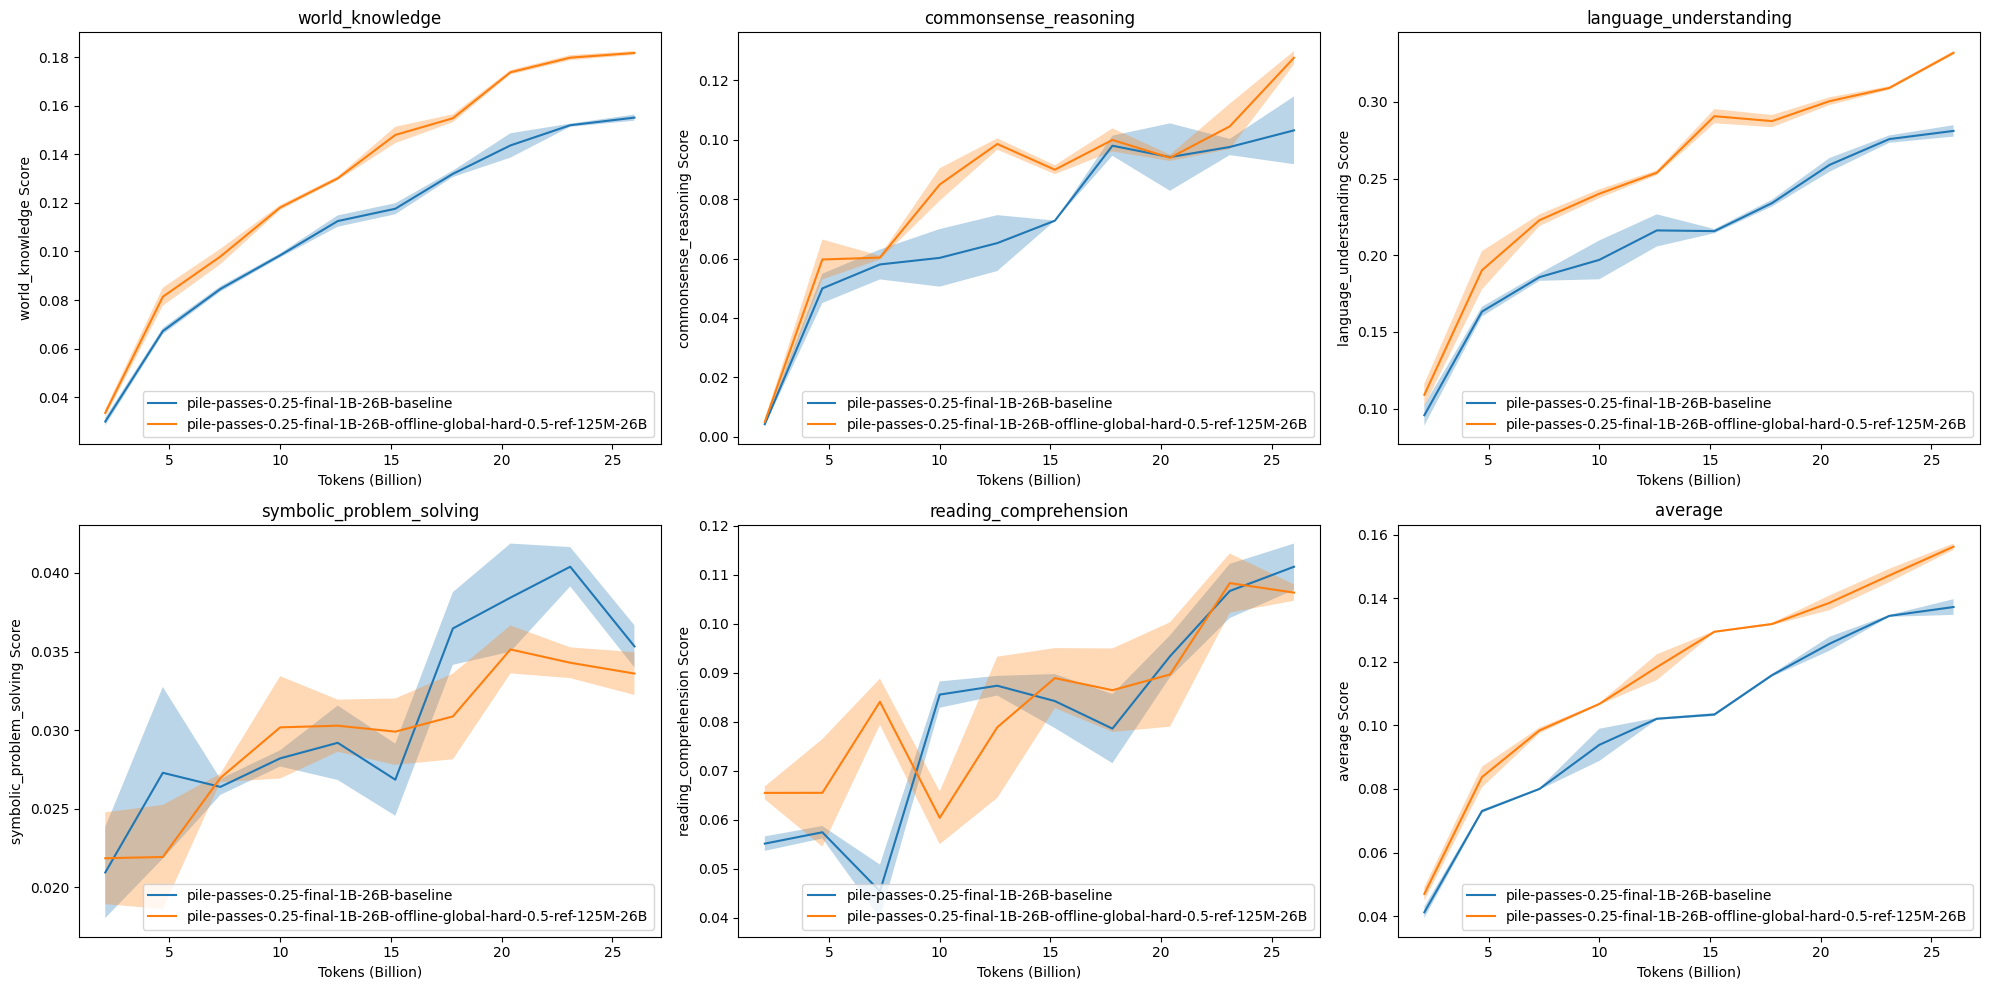

In [7]:
plot_all_results(pile_1b_processed_results)

In [8]:
print_tex_table(pile_1b_processed_results, 26.0, raw=False)

RAW_METRICS
pile-passes-0.25-final-1B-26B-baseline: 
&  26.32  &  48.13  &  52.07  &  \textbf{8.56}  &  \textbf{29.94}  &  33.0     \\
pile-passes-0.25-final-1B-26B-offline-global-easy-0.5-ref-125M-26B: 
&  22.49  &  45.64  &  45.44  &  \textbf{8.67}  &  27.96  &  30.04     \\
pile-passes-0.25-final-1B-26B-offline-global-mid-0.5-ref-125M-26B: 
&  26.86  &  47.46  &  52.14  &  8.41  &  \textbf{29.76}  &  32.92     \\
pile-passes-0.25-final-1B-26B-offline-global-hard-0.5-ref-125M-26B: 
&  \textbf{28.87}  &  \textbf{49.71}  &  \textbf{55.45}  &  \textbf{8.41}  &  \textbf{29.61}  &  \textbf{34.41}     \\
NORMALIZED_METRICS
pile-passes-0.25-final-1B-26B-baseline: 
&  15.51  &  10.31  &  28.11  &  \textbf{3.53}  &  \textbf{11.16}  &  13.73     \\
pile-passes-0.25-final-1B-26B-offline-global-easy-0.5-ref-125M-26B: 
&  11.14  &  5.76  &  18.66  &  \textbf{3.54}  &  8.72  &  9.56     \\
pile-passes-0.25-final-1B-26B-offline-global-mid-0.5-ref-125M-26B: 
&  16.12  &  9.01  &  28.1  &  \textbf{3.

## MPT 1b results

In [9]:
mpt_1b_processed_results = pickle.load(open("data/evals/mpt_1b_processed_results.pkl", "rb"))

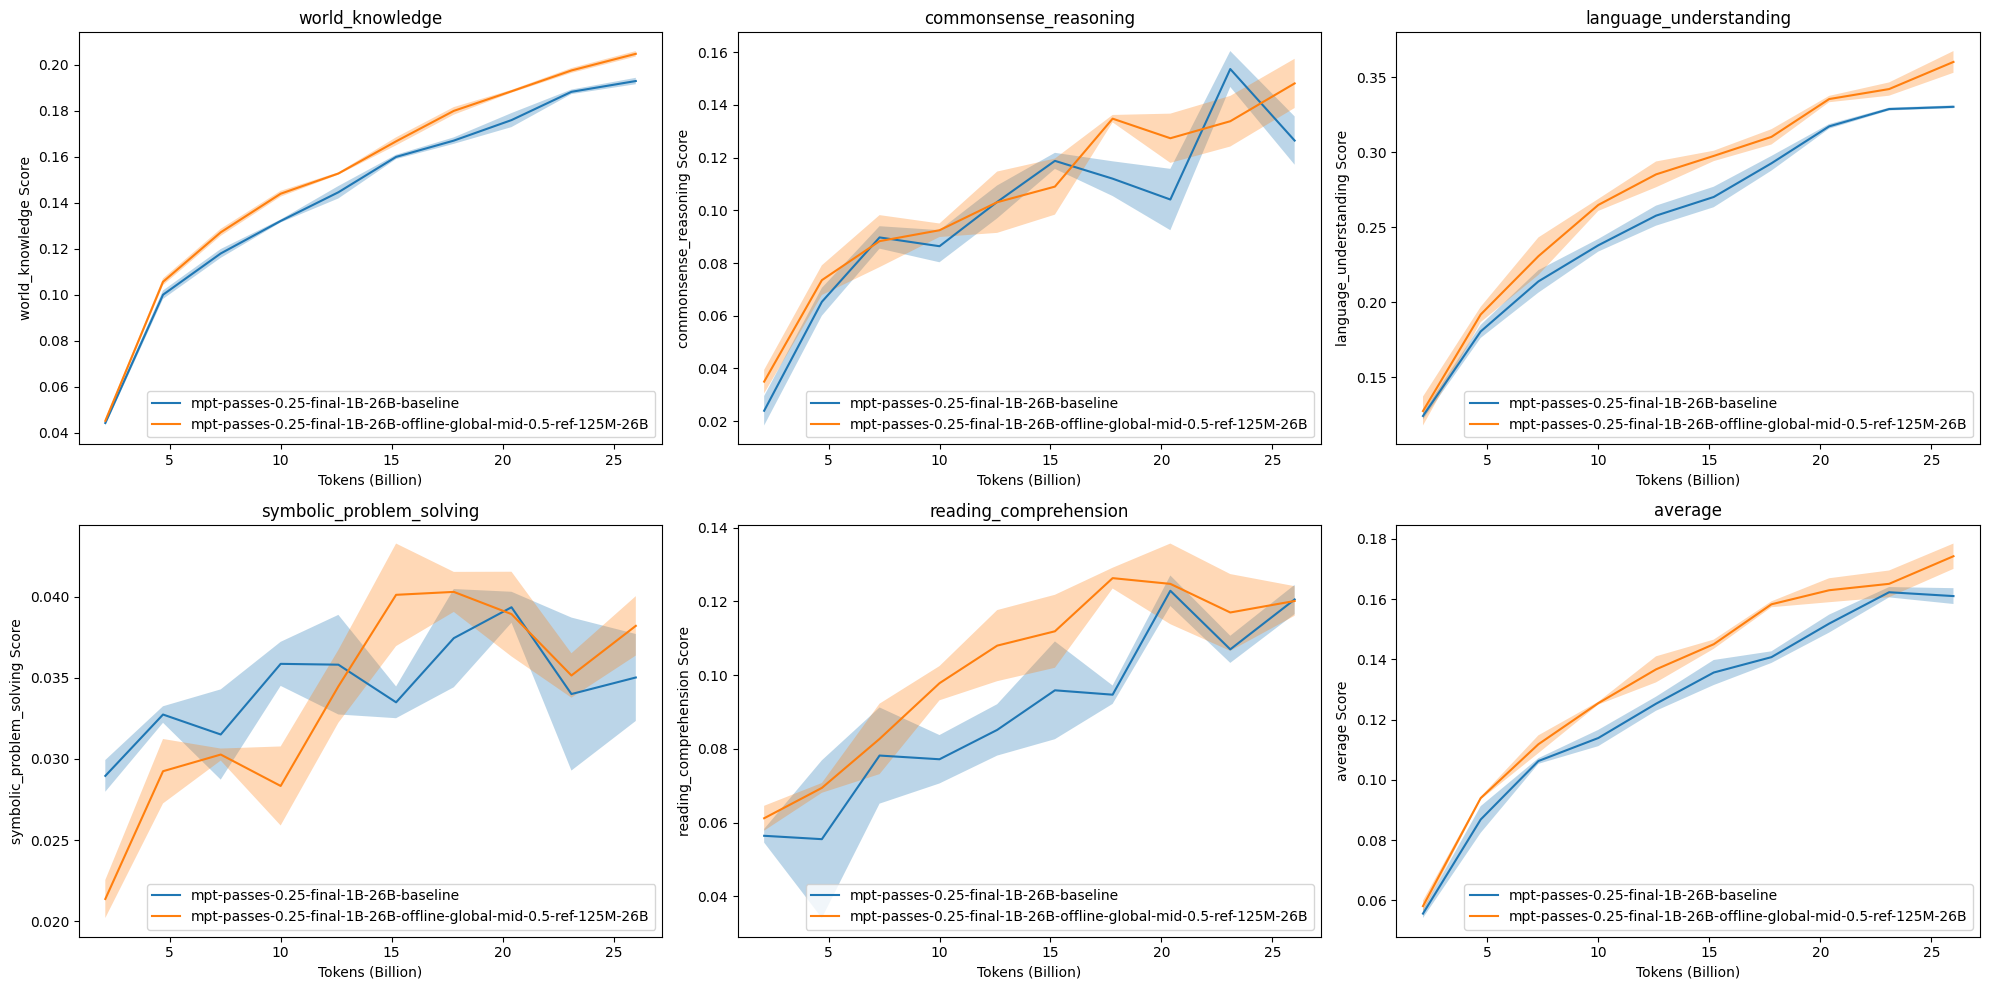

In [10]:
plot_all_results(mpt_1b_processed_results)

In [11]:
print_tex_table(mpt_1b_processed_results, 26.0)

RAW_METRICS
mpt-passes-0.25-final-1B-26B-baseline: 
&  29.8  &  \textbf{49.68}  &  55.97  &  \textbf{8.59}  &  32.02  &  35.21     \\
mpt-passes-0.25-final-1B-26B-offline-global-easy-0.5-ref-125M-26B: 
&  29.17  &  \textbf{49.99}  &  55.84  &  \textbf{9.01}  &  \textbf{32.88}  &  35.38     \\
mpt-passes-0.25-final-1B-26B-offline-global-mid-0.5-ref-125M-26B: 
&  \textbf{30.88}  &  \textbf{50.82}  &  \textbf{57.83}  &  \textbf{8.86}  &  31.83  &  \textbf{36.04}     \\
mpt-passes-0.25-final-1B-26B-offline-global-hard-0.5-ref-125M-26B: 
&  29.67  &  49.36  &  56.56  &  \textbf{8.79}  &  30.32  &  34.94     \\
NORMALIZED_METRICS
mpt-passes-0.25-final-1B-26B-baseline: 
&  19.3  &  12.65  &  33.02  &  \textbf{3.5}  &  12.05  &  16.1     \\
mpt-passes-0.25-final-1B-26B-offline-global-easy-0.5-ref-125M-26B: 
&  18.64  &  \textbf{13.33}  &  32.99  &  \textbf{3.98}  &  \textbf{13.58}  &  16.5     \\
mpt-passes-0.25-final-1B-26B-offline-global-mid-0.5-ref-125M-26B: 
&  \textbf{20.48}  &  \textbf{1

## Dolma 1B Results

In [12]:
dolma_1b_processed_results = pickle.load(open("data/evals/dolma_1b_processed_results.pkl", "rb"))

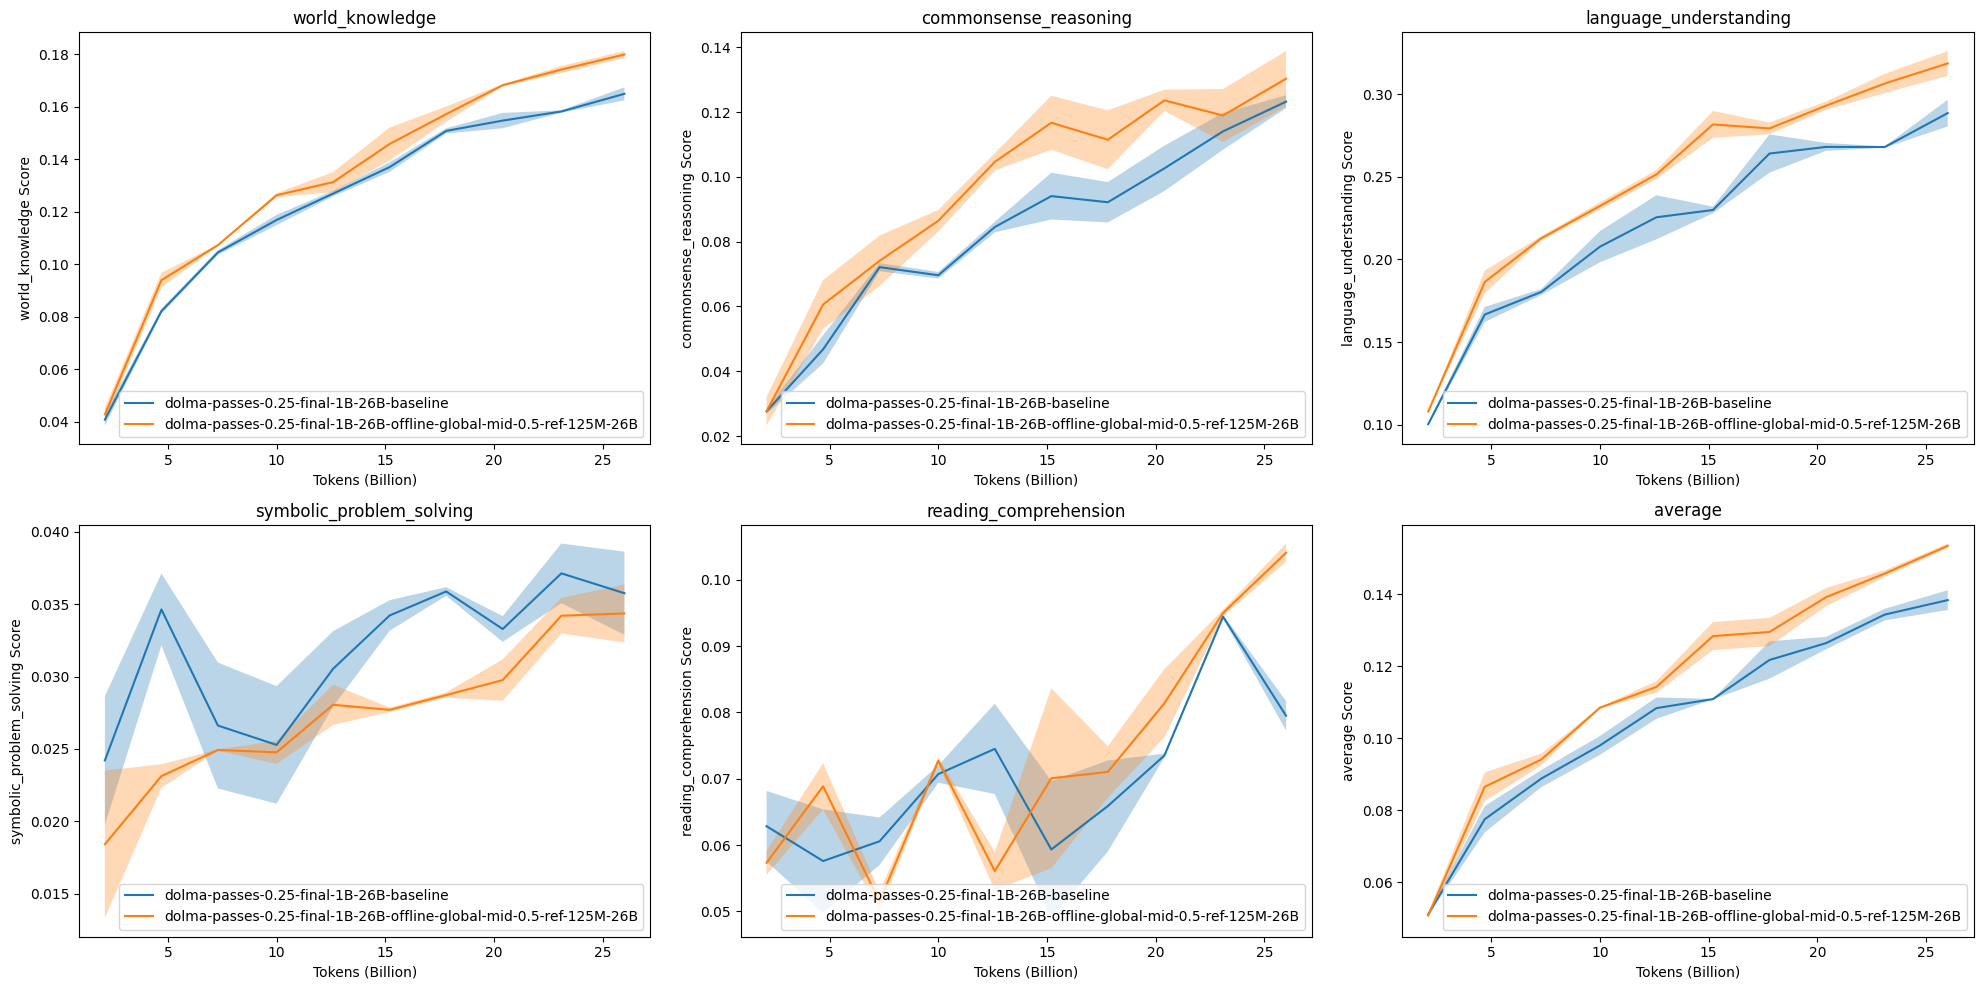

In [13]:
plot_all_results(dolma_1b_processed_results)

In [14]:
print_tex_table(dolma_1b_processed_results, 26.0)

RAW_METRICS
dolma-passes-0.25-final-1B-26B-baseline: 
&  27.36  &  \textbf{49.37}  &  52.24  &  \textbf{8.62}  &  27.7  &  33.06     \\
dolma-passes-0.25-final-1B-26B-offline-global-easy-0.5-ref-125M-26B: 
&  26.97  &  48.07  &  51.33  &  \textbf{8.4}  &  28.48  &  32.65     \\
dolma-passes-0.25-final-1B-26B-offline-global-mid-0.5-ref-125M-26B: 
&  \textbf{28.62}  &  \textbf{49.64}  &  \textbf{54.14}  &  \textbf{8.4}  &  \textbf{29.2}  &  \textbf{34.0}     \\
dolma-passes-0.25-final-1B-26B-offline-global-hard-0.5-ref-125M-26B: 
&  27.49  &  \textbf{49.61}  &  \textbf{53.86}  &  8.18  &  27.98  &  33.42     \\
NORMALIZED_METRICS
dolma-passes-0.25-final-1B-26B-baseline: 
&  16.48  &  12.32  &  28.86  &  \textbf{3.58}  &  7.95  &  13.84     \\
dolma-passes-0.25-final-1B-26B-offline-global-easy-0.5-ref-125M-26B: 
&  16.13  &  10.1  &  27.28  &  \textbf{3.45}  &  7.85  &  12.96     \\
dolma-passes-0.25-final-1B-26B-offline-global-mid-0.5-ref-125M-26B: 
&  \textbf{17.98}  &  \textbf{13.03}  

## Selection rate pile results

In [15]:
selection_rate_pile_1b_processed_results = pickle.load(open("data/evals/selection_rate_pile_1b_processed_results.pkl", "rb"))

In [16]:
print_tex_table(selection_rate_pile_1b_processed_results, 26.0)

RAW_METRICS
pile-passes-0.25-final-1B-26B-offline-global-hard-0.25-ref-125M-26B: 
&  \textbf{28.99}  &  49.47  &  \textbf{56.11}  &  \textbf{8.63}  &  \textbf{28.83}  &  \textbf{34.41}     \\
pile-passes-0.25-final-1B-26B-offline-global-hard-0.5-ref-125M-26B: 
&  \textbf{28.87}  &  \textbf{49.71}  &  55.45  &  \textbf{8.41}  &  \textbf{29.61}  &  \textbf{34.41}     \\
pile-passes-0.25-final-1B-26B-offline-global-hard-0.75-ref-125M-26B: 
&  27.86  &  47.99  &  54.13  &  \textbf{8.84}  &  28.57  &  33.48     \\
NORMALIZED_METRICS
pile-passes-0.25-final-1B-26B-offline-global-hard-0.25-ref-125M-26B: 
&  \textbf{18.21}  &  \textbf{12.88}  &  \textbf{34.44}  &  \textbf{3.73}  &  \textbf{9.44}  &  \textbf{15.74}     \\
pile-passes-0.25-final-1B-26B-offline-global-hard-0.5-ref-125M-26B: 
&  \textbf{18.18}  &  \textbf{12.75}  &  33.2  &  3.36  &  \textbf{10.63}  &  \textbf{15.62}     \\
pile-passes-0.25-final-1B-26B-offline-global-hard-0.75-ref-125M-26B: 
&  17.08  &  10.11  &  31.37  &  \textb

## Selection rate mpt 1b results

In [17]:
selection_rate_mpt_1b_processed_results = pickle.load(open("data/evals/selection_rate_mpt_1b_processed_results.pkl", "rb"))

In [18]:
print_tex_table(selection_rate_mpt_1b_processed_results, 26.0)

RAW_METRICS
mpt-passes-0.25-final-1B-26B-offline-global-mid-0.25-ref-125M-26B: 
&  30.56  &  49.6  &  \textbf{57.5}  &  \textbf{9.26}  &  30.88  &  35.56     \\
mpt-passes-0.25-final-1B-26B-offline-global-mid-0.5-ref-125M-26B: 
&  \textbf{30.88}  &  \textbf{50.82}  &  \textbf{57.83}  &  8.86  &  \textbf{31.83}  &  \textbf{36.04}     \\
mpt-passes-0.25-final-1B-26B-offline-global-mid-0.75-ref-125M-26B: 
&  29.94  &  \textbf{50.81}  &  \textbf{57.52}  &  8.6  &  \textbf{31.98}  &  \textbf{35.77}     \\
NORMALIZED_METRICS
mpt-passes-0.25-final-1B-26B-offline-global-mid-0.25-ref-125M-26B: 
&  20.05  &  12.62  &  \textbf{35.43}  &  \textbf{4.24}  &  10.84  &  16.64     \\
mpt-passes-0.25-final-1B-26B-offline-global-mid-0.5-ref-125M-26B: 
&  \textbf{20.48}  &  \textbf{14.81}  &  \textbf{36.01}  &  3.82  &  \textbf{12.01}  &  \textbf{17.43}     \\
mpt-passes-0.25-final-1B-26B-offline-global-mid-0.75-ref-125M-26B: 
&  19.33  &  \textbf{14.49}  &  \textbf{35.66}  &  3.53  &  \textbf{11.52}  &  

## Selection rate dolma 1B results

In [19]:
selection_rate_dolma_1b_processed_results = pickle.load(open("data/evals/selection_rate_dolma_1b_processed_results.pkl", "rb"))

In [20]:
print_tex_table(selection_rate_dolma_1b_processed_results, 26.0)

RAW_METRICS
dolma-passes-0.25-final-1B-26B-offline-global-mid-0.25-ref-125M-26B: 
&  28.57  &  \textbf{49.14}  &  \textbf{54.38}  &  \textbf{8.51}  &  28.46  &  33.81     \\
dolma-passes-0.25-final-1B-26B-offline-global-mid-0.5-ref-125M-26B: 
&  \textbf{28.62}  &  \textbf{49.64}  &  \textbf{54.14}  &  \textbf{8.4}  &  29.2  &  \textbf{34.0}     \\
dolma-passes-0.25-final-1B-26B-offline-global-mid-0.75-ref-125M-26B: 
&  \textbf{28.78}  &  49.02  &  53.06  &  \textbf{8.4}  &  \textbf{30.09}  &  \textbf{33.87}     \\
NORMALIZED_METRICS
dolma-passes-0.25-final-1B-26B-offline-global-mid-0.25-ref-125M-26B: 
&  17.94  &  \textbf{12.16}  &  \textbf{31.63}  &  \textbf{3.58}  &  8.91  &  14.85     \\
dolma-passes-0.25-final-1B-26B-offline-global-mid-0.5-ref-125M-26B: 
&  \textbf{17.98}  &  \textbf{13.03}  &  \textbf{31.87}  &  \textbf{3.44}  &  10.41  &  \textbf{15.35}     \\
dolma-passes-0.25-final-1B-26B-offline-global-mid-0.75-ref-125M-26B: 
&  \textbf{18.2}  &  11.78  &  29.96  &  \textbf{3.

## Pile 3B results

In [21]:
pile_3b_processed_results = pickle.load(open("data/evals/pile_3b_processed_results.pkl", "rb"))

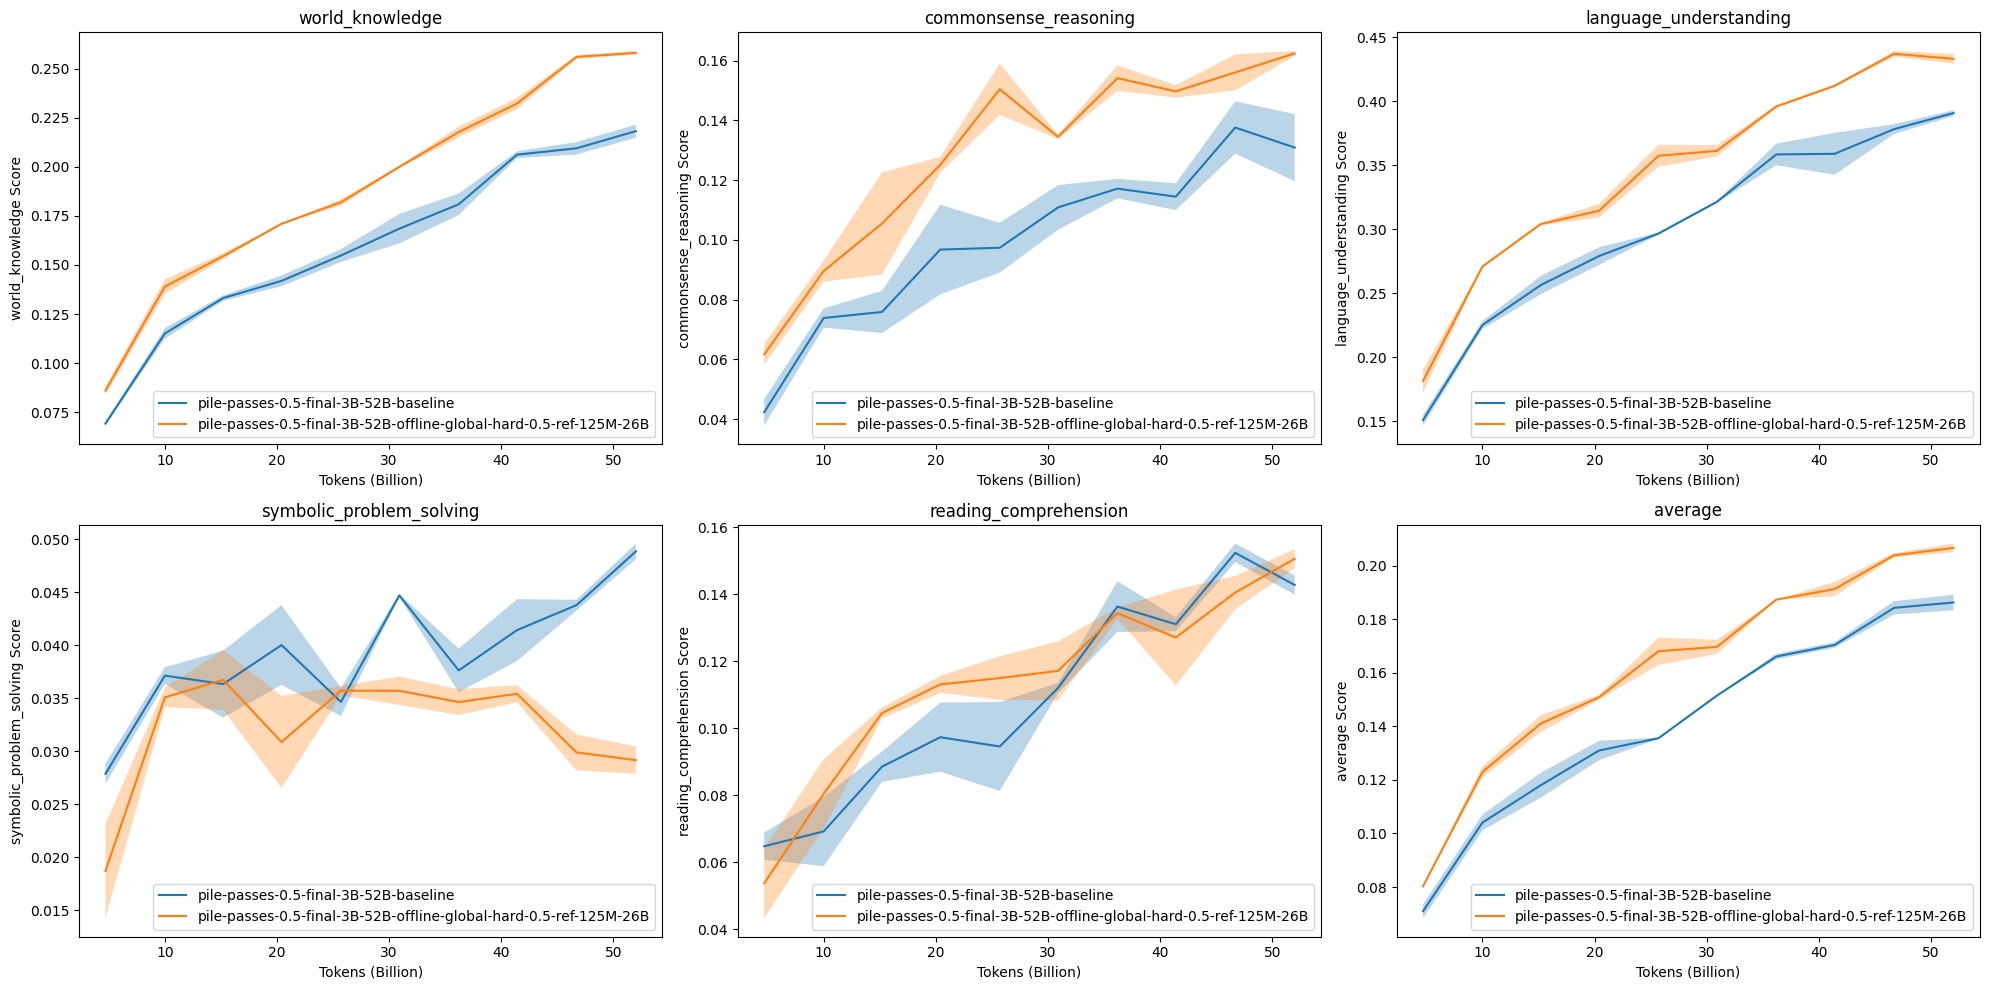

In [22]:
plot_all_results(pile_3b_processed_results)

In [23]:
print_tex_table(pile_3b_processed_results, 52.0)

RAW_METRICS
pile-passes-0.5-final-3B-52B-baseline: 
&  32.17  &  49.88  &  59.23  &  \textbf{9.93}  &  \textbf{33.06}  &  36.86     \\
pile-passes-0.5-final-3B-52B-offline-global-hard-0.5-ref-125M-26B: 
&  \textbf{35.84}  &  \textbf{51.47}  &  \textbf{62.07}  &  8.06  &  \textbf{33.63}  &  \textbf{38.21}     \\
NORMALIZED_METRICS
pile-passes-0.5-final-3B-52B-baseline: 
&  21.82  &  13.09  &  39.08  &  \textbf{4.88}  &  14.28  &  18.63     \\
pile-passes-0.5-final-3B-52B-offline-global-hard-0.5-ref-125M-26B: 
&  \textbf{25.8}  &  \textbf{16.24}  &  \textbf{43.32}  &  2.91  &  \textbf{15.07}  &  \textbf{20.67}     \\


## MPT 3b results

In [24]:
mpt_3b_processed_results = pickle.load(open("data/evals/mpt_3b_processed_results.pkl", "rb"))

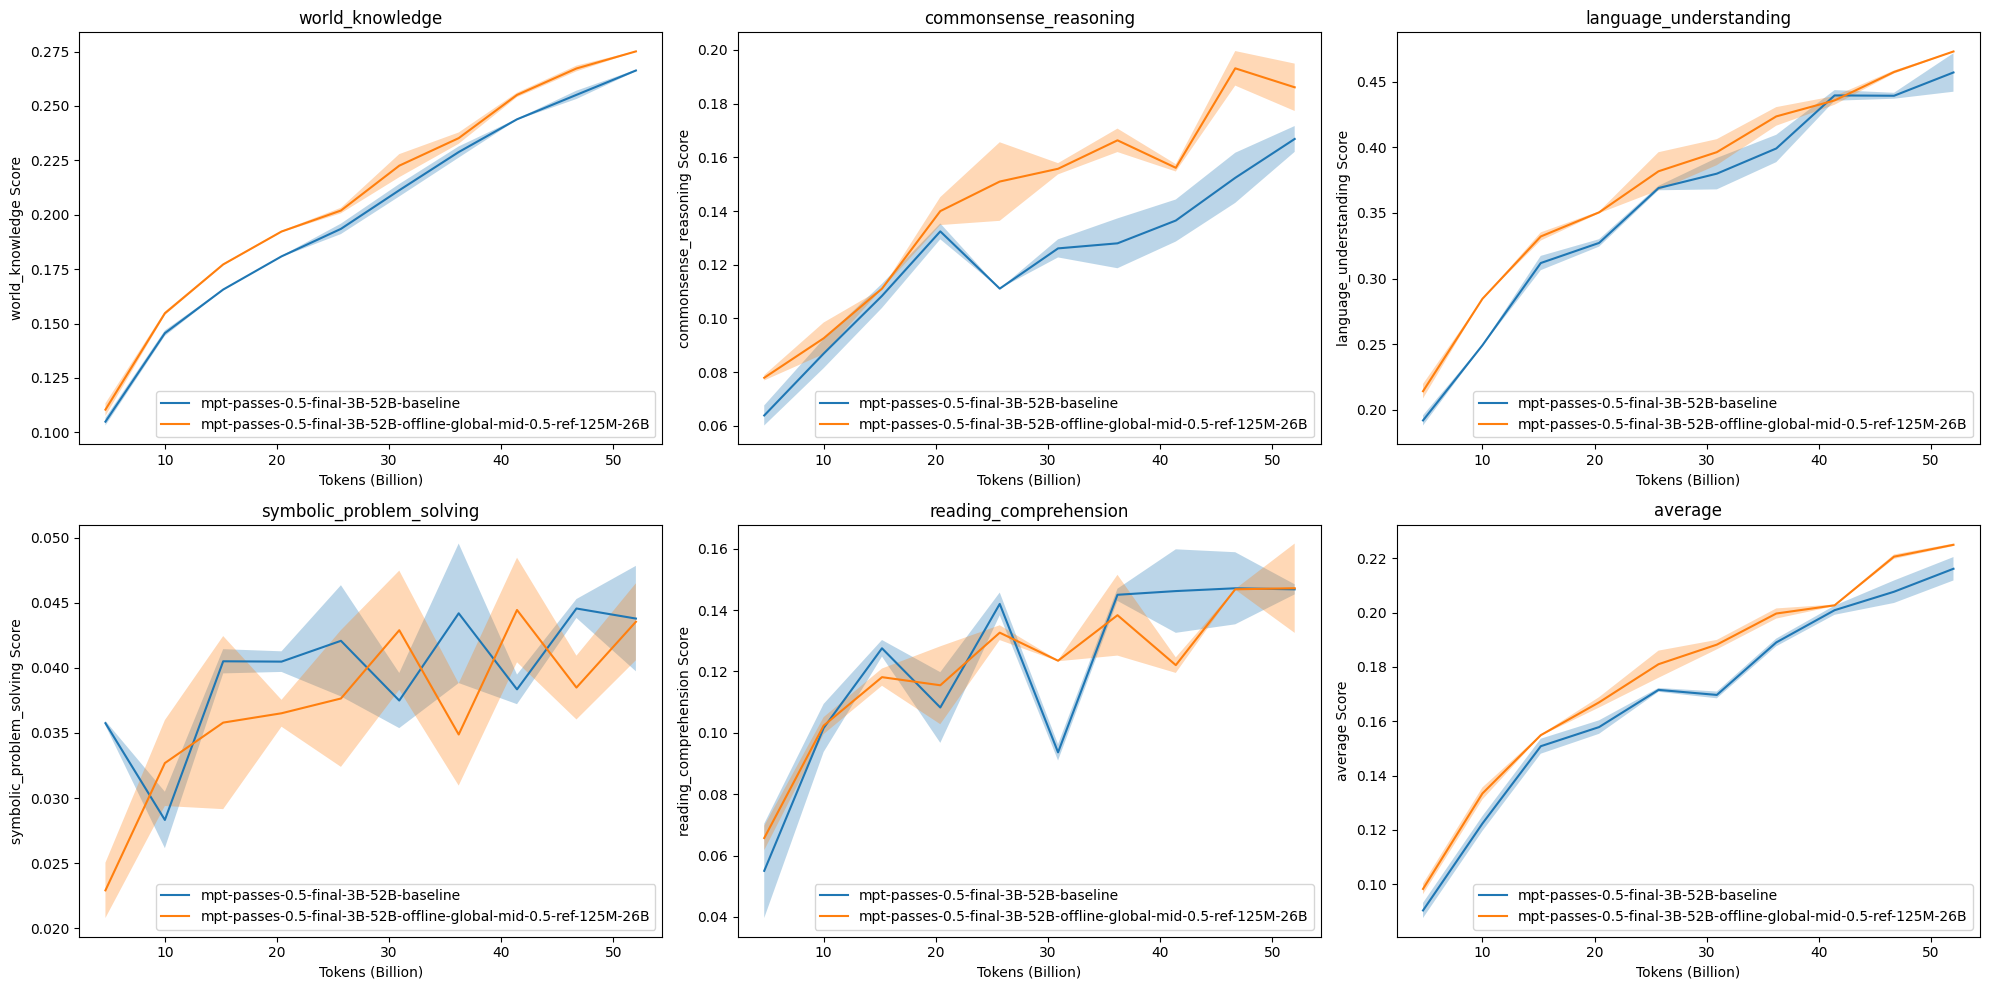

In [25]:
plot_all_results(mpt_3b_processed_results)

In [26]:
print_tex_table(mpt_3b_processed_results, 52.0)

RAW_METRICS
mpt-passes-0.5-final-3B-52B-baseline: 
&  36.5  &  51.75  &  64.15  &  \textbf{9.4}  &  \textbf{34.17}  &  39.19     \\
mpt-passes-0.5-final-3B-52B-offline-global-mid-0.5-ref-125M-26B: 
&  \textbf{37.25}  &  \textbf{52.83}  &  \textbf{65.37}  &  \textbf{9.43}  &  \textbf{34.78}  &  \textbf{39.93}     \\
NORMALIZED_METRICS
mpt-passes-0.5-final-3B-52B-baseline: 
&  26.63  &  16.69  &  45.69  &  \textbf{4.38}  &  \textbf{14.68}  &  21.61     \\
mpt-passes-0.5-final-3B-52B-offline-global-mid-0.5-ref-125M-26B: 
&  \textbf{27.51}  &  \textbf{18.61}  &  \textbf{47.29}  &  \textbf{4.35}  &  \textbf{14.71}  &  \textbf{22.49}     \\


## Dolma 3B results

In [27]:
dolma_3b_processed_results = pickle.load(open("data/evals/dolma_3b_processed_results.pkl", "rb"))

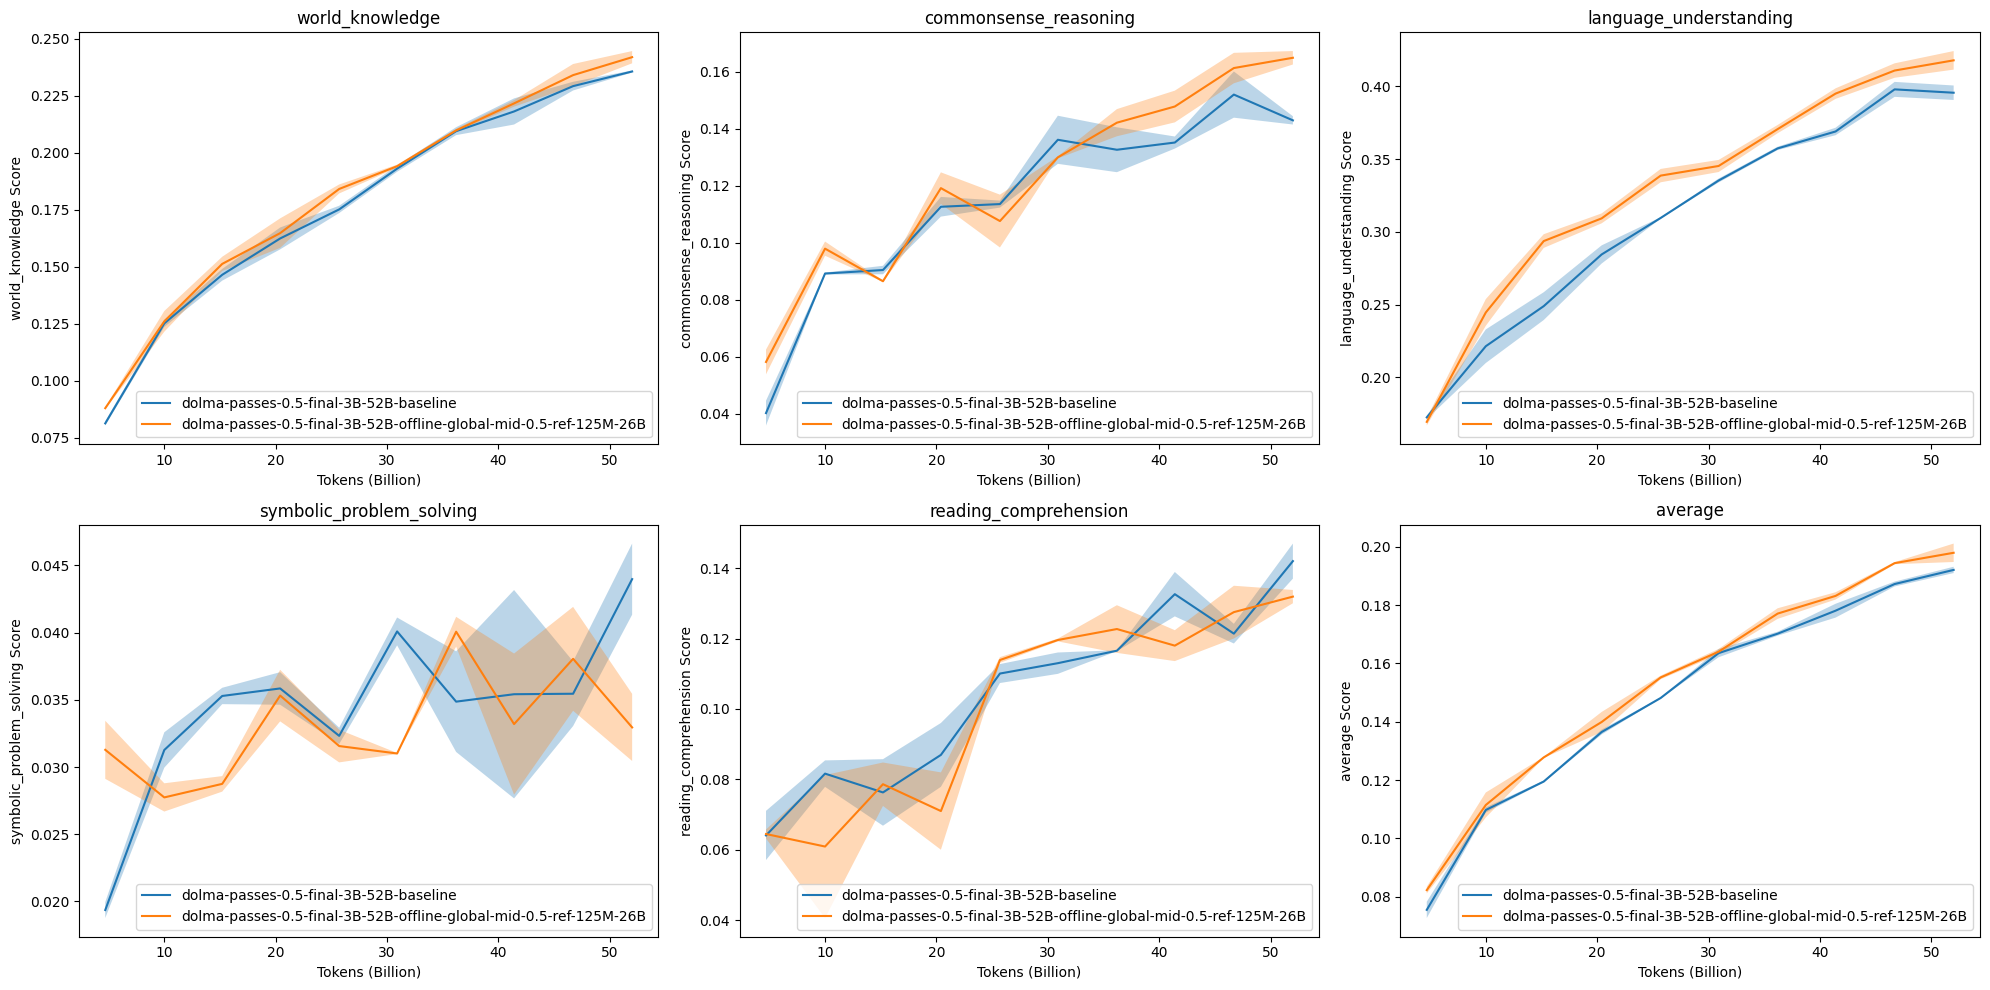

In [28]:
plot_all_results(dolma_3b_processed_results)

In [29]:
print_tex_table(dolma_3b_processed_results, 52.0)

RAW_METRICS
dolma-passes-0.5-final-3B-52B-baseline: 
&  33.7  &  50.46  &  59.29  &  \textbf{9.39}  &  \textbf{32.77}  &  \textbf{37.12}     \\
dolma-passes-0.5-final-3B-52B-offline-global-mid-0.5-ref-125M-26B: 
&  \textbf{34.18}  &  \textbf{51.61}  &  \textbf{60.8}  &  8.34  &  31.73  &  \textbf{37.33}     \\
NORMALIZED_METRICS
dolma-passes-0.5-final-3B-52B-baseline: 
&  23.56  &  14.29  &  39.57  &  \textbf{4.4}  &  \textbf{14.2}  &  19.2     \\
dolma-passes-0.5-final-3B-52B-offline-global-mid-0.5-ref-125M-26B: 
&  \textbf{24.19}  &  \textbf{16.48}  &  \textbf{41.8}  &  3.3  &  13.19  &  \textbf{19.79}     \\


# Over trained model results

## Pile 5x tokens

In [30]:
pile_5x_tokens_processed_results = pickle.load(open("data/evals/pile_5x_tokens_processed_results.pkl", "rb"))

In [31]:
print_tex_table(pile_5x_tokens_processed_results, 130.0)

RAW_METRICS
pile-passes-0.5-final-1B-130B-baseline: 
&  30.68  &  48.98  &  57.32  &  \textbf{8.83}  &  32.1  &  35.58     \\
pile-passes-0.5-final-1B-130B-offline-global-hard-0.5-ref-125M-26B: 
&  \textbf{33.63}  &  \textbf{49.93}  &  \textbf{60.27}  &  \textbf{8.44}  &  \textbf{32.81}  &  \textbf{37.02}     \\
NORMALIZED_METRICS
pile-passes-0.5-final-1B-130B-baseline: 
&  20.16  &  11.85  &  36.11  &  \textbf{3.8}  &  \textbf{13.54}  &  17.09     \\
pile-passes-0.5-final-1B-130B-offline-global-hard-0.5-ref-125M-26B: 
&  \textbf{23.43}  &  \textbf{13.46}  &  \textbf{40.15}  &  \textbf{3.44}  &  \textbf{13.69}  &  \textbf{18.83}     \\


## Dolma 5x tokens

In [32]:
dolma_5x_tokens_processed_results = pickle.load(open("data/evals/dolma_5x_tokens_processed_results.pkl", "rb"))

In [33]:
print_tex_table(dolma_5x_tokens_processed_results, 130.0)

RAW_METRICS
dolma-passes-0.5-final-1B-130B-baseline: 
&  32.56  &  50.21  &  57.3  &  \textbf{8.81}  &  \textbf{31.66}  &  36.11     \\
dolma-passes-0.5-final-1B-130B-offline-global-mid-0.5-ref-125M-26B: 
&  \textbf{33.18}  &  \textbf{51.42}  &  \textbf{58.65}  &  8.09  &  \textbf{31.48}  &  \textbf{36.56}     \\
NORMALIZED_METRICS
dolma-passes-0.5-final-1B-130B-baseline: 
&  22.28  &  13.76  &  36.35  &  \textbf{3.81}  &  \textbf{12.95}  &  17.83     \\
dolma-passes-0.5-final-1B-130B-offline-global-mid-0.5-ref-125M-26B: 
&  \textbf{22.91}  &  \textbf{16.38}  &  \textbf{38.27}  &  3.06  &  \textbf{12.72}  &  \textbf{18.67}     \\


# Pile Repeats

In [34]:
pile_repeats_processed_results = pickle.load(open("data/evals/pile_repeats_processed_results.pkl", "rb"))

In [35]:
print_tex_table(pile_repeats_processed_results, 26.0)

RAW_METRICS
pile-passes-0.25-final-1B-26B-baseline: 
&  26.32  &  48.13  &  52.07  &  8.56  &  \textbf{29.94}  &  33.0     \\
pile-passes-2.0-final-1B-26B-baseline: 
&  26.75  &  49.0  &  52.03  &  \textbf{9.01}  &  28.89  &  33.14     \\
pile-passes-4.0-final-1B-26B-baseline: 
&  26.31  &  48.25  &  51.96  &  \textbf{9.19}  &  29.27  &  32.99     \\
pile-passes-8.0-final-1B-26B-baseline: 
&  25.1  &  47.91  &  49.82  &  \textbf{9.06}  &  27.35  &  31.85     \\
pile-passes-0.25-final-1B-26B-offline-global-hard-0.5-ref-125M-26B: 
&  \textbf{28.87}  &  \textbf{49.71}  &  \textbf{55.45}  &  8.41  &  \textbf{29.61}  &  \textbf{34.41}     \\
pile-passes-1.0-final-1B-26B-offline-global-hard-0.5-ref-125M-26B: 
&  \textbf{28.59}  &  \textbf{49.82}  &  \textbf{54.96}  &  8.49  &  \textbf{29.49}  &  \textbf{34.27}     \\
pile-passes-2.0-final-1B-26B-offline-global-hard-0.5-ref-125M-26B: 
&  28.49  &  \textbf{49.65}  &  \textbf{55.11}  &  8.13  &  \textbf{29.58}  &  34.19     \\
pile-passes-4.0-f

## MPT repeats

In [36]:
mpt_repeats_processed_results = pickle.load(open("data/evals/mpt_repeats_processed_results.pkl", "rb"))

In [37]:
print_tex_table(mpt_repeats_processed_results, 26.0)

RAW_METRICS
mpt-passes-0.25-final-1B-26B-baseline: 
&  29.8  &  49.68  &  55.97  &  8.59  &  32.02  &  35.21     \\
mpt-passes-2.0-final-1B-26B-baseline: 
&  29.88  &  \textbf{50.86}  &  56.45  &  8.22  &  31.05  &  35.29     \\
mpt-passes-4.0-final-1B-26B-baseline: 
&  29.06  &  50.12  &  56.13  &  \textbf{9.94}  &  \textbf{33.09}  &  35.67     \\
mpt-passes-8.0-final-1B-26B-baseline: 
&  27.44  &  49.35  &  54.99  &  8.22  &  29.78  &  33.96     \\
mpt-passes-0.25-final-1B-26B-offline-global-mid-0.5-ref-125M-26B: 
&  \textbf{30.88}  &  \textbf{50.82}  &  \textbf{57.83}  &  8.86  &  31.83  &  \textbf{36.04}     \\
mpt-passes-1.0-final-1B-26B-offline-global-mid-0.5-ref-125M-26B: 
&  \textbf{30.86}  &  49.97  &  \textbf{57.17}  &  8.55  &  30.42  &  35.4     \\
mpt-passes-2.0-final-1B-26B-offline-global-mid-0.5-ref-125M-26B: 
&  30.24  &  \textbf{50.68}  &  56.6  &  8.6  &  30.51  &  35.33     \\
mpt-passes-4.0-final-1B-26B-offline-global-mid-0.5-ref-125M-26B: 
&  28.87  &  49.99  &  56

## Dolma Repeats Results

In [38]:
dolma_repeats_processed_results = pickle.load(open("data/evals/dolma_repeats_processed_results.pkl", "rb"))

In [39]:
print_tex_table(dolma_repeats_processed_results, 26.0)

RAW_METRICS
dolma-passes-0.25-final-1B-26B-baseline: 
&  27.36  &  \textbf{49.37}  &  52.24  &  \textbf{8.62}  &  27.7  &  33.06     \\
dolma-passes-2.0-final-1B-26B-baseline: 
&  28.06  &  49.18  &  52.15  &  8.03  &  \textbf{29.1}  &  33.3     \\
dolma-passes-4.0-final-1B-26B-baseline: 
&  27.12  &  \textbf{49.54}  &  51.47  &  \textbf{8.68}  &  28.11  &  32.98     \\
dolma-passes-8.0-final-1B-26B-baseline: 
&  26.16  &  48.29  &  49.6  &  8.15  &  27.32  &  31.91     \\
dolma-passes-0.25-final-1B-26B-offline-global-mid-0.5-ref-125M-26B: 
&  \textbf{28.62}  &  \textbf{49.64}  &  \textbf{54.14}  &  8.4  &  \textbf{29.2}  &  \textbf{34.0}     \\
dolma-passes-1.0-final-1B-26B-offline-global-mid-0.5-ref-125M-26B: 
&  28.25  &  \textbf{49.87}  &  \textbf{53.59}  &  8.03  &  28.62  &  33.67     \\
dolma-passes-2.0-final-1B-26B-offline-global-mid-0.5-ref-125M-26B: 
&  27.89  &  49.39  &  \textbf{53.86}  &  \textbf{8.4}  &  28.53  &  33.61     \\
dolma-passes-4.0-final-1B-26B-offline-global-

# Plotting for the paper to be fancy

In [40]:
colors = [
    "#EE3932",
    "#241E4E",
]
background = "#EEEDE9"
subplot_labels = ["(a)", "(b)", "(c)", "(d)", "(e)", "(f)"]

def plot_paper_results(groups, save_name="", raw=False):
    # Calculate the number of rows needed for the subplots
    rows = math.ceil((len(groups)) / 2)

    fig, axs = plt.subplots(rows, 2, figsize=(20, 8*rows))  # Create a grid of subplots

    # Flatten the axs array for easy iteration
    axs = axs.flatten()

    # Iterate over each category (metric)
    for i, group in enumerate(groups):
    
        title = group["title"]
        group_results = group["results"]

        # Iterate over each run
        for result_idx, result_set in enumerate(group_results):
            run_name = result_set["run_name"]
            step_metrics = result_set["step_metrics"]

            steps = sorted(step_metrics.keys())
        
            # Get the metric values for the current category
            key = "raw_metrics" if raw else "normalized_metrics"
            avg_metrics = [step_metrics[step][key]["avgs"][-1] * 100 for step in steps]
            ste_metrics = [step_metrics[step][key]["stes"][-1] * 100 for step in steps]
        
            axs[i].plot(steps, avg_metrics, label=run_name, color=colors[result_idx], marker="o", zorder=2, linewidth=2, markersize=8)
            axs[i].fill_between(steps, np.array(avg_metrics) - np.array(ste_metrics), np.array(avg_metrics) + np.array(ste_metrics), color=colors[result_idx], alpha=0.2, zorder=2)
        
        axs[i].legend(loc="lower right", frameon=True, fontsize=21)

        # Label information
        axs[i].set_ylabel("Avg. Task Accuracy (%)", fontsize=20)
        axs[i].set_xlabel("Token Duration (Billion)", fontsize=20)
        axs[i].set_title(title, fontsize=24, fontweight="bold", pad=20)

        # Change background color
        axs[i].set_facecolor(background) 
        axs[i].grid(True, color='white', zorder=1)

        # Remove the borders from the graph
        axs[i].spines['top'].set_visible(False)
        axs[i].spines['right'].set_visible(False)
        axs[i].spines['bottom'].set_visible(False)
        axs[i].spines['left'].set_visible(False)

        # Format the ticks
        axs[i].tick_params(axis='both', which='both', bottom=False, left=False, top=False, right=False, labelsize=16)

        # Label subplot
        axs[i].text(0, 1.1, subplot_labels[i], transform=axs[i].transAxes, fontsize=16, fontweight='bold', va='top', ha='right')

    # Remove any unused subplots
    for i in range(len(metric_names), len(axs)):
        fig.delaxes(axs[i])

    plt.tight_layout()

    # Save the figure to disk
    if save_name:
        plt.savefig(save_name)

    plt.show()

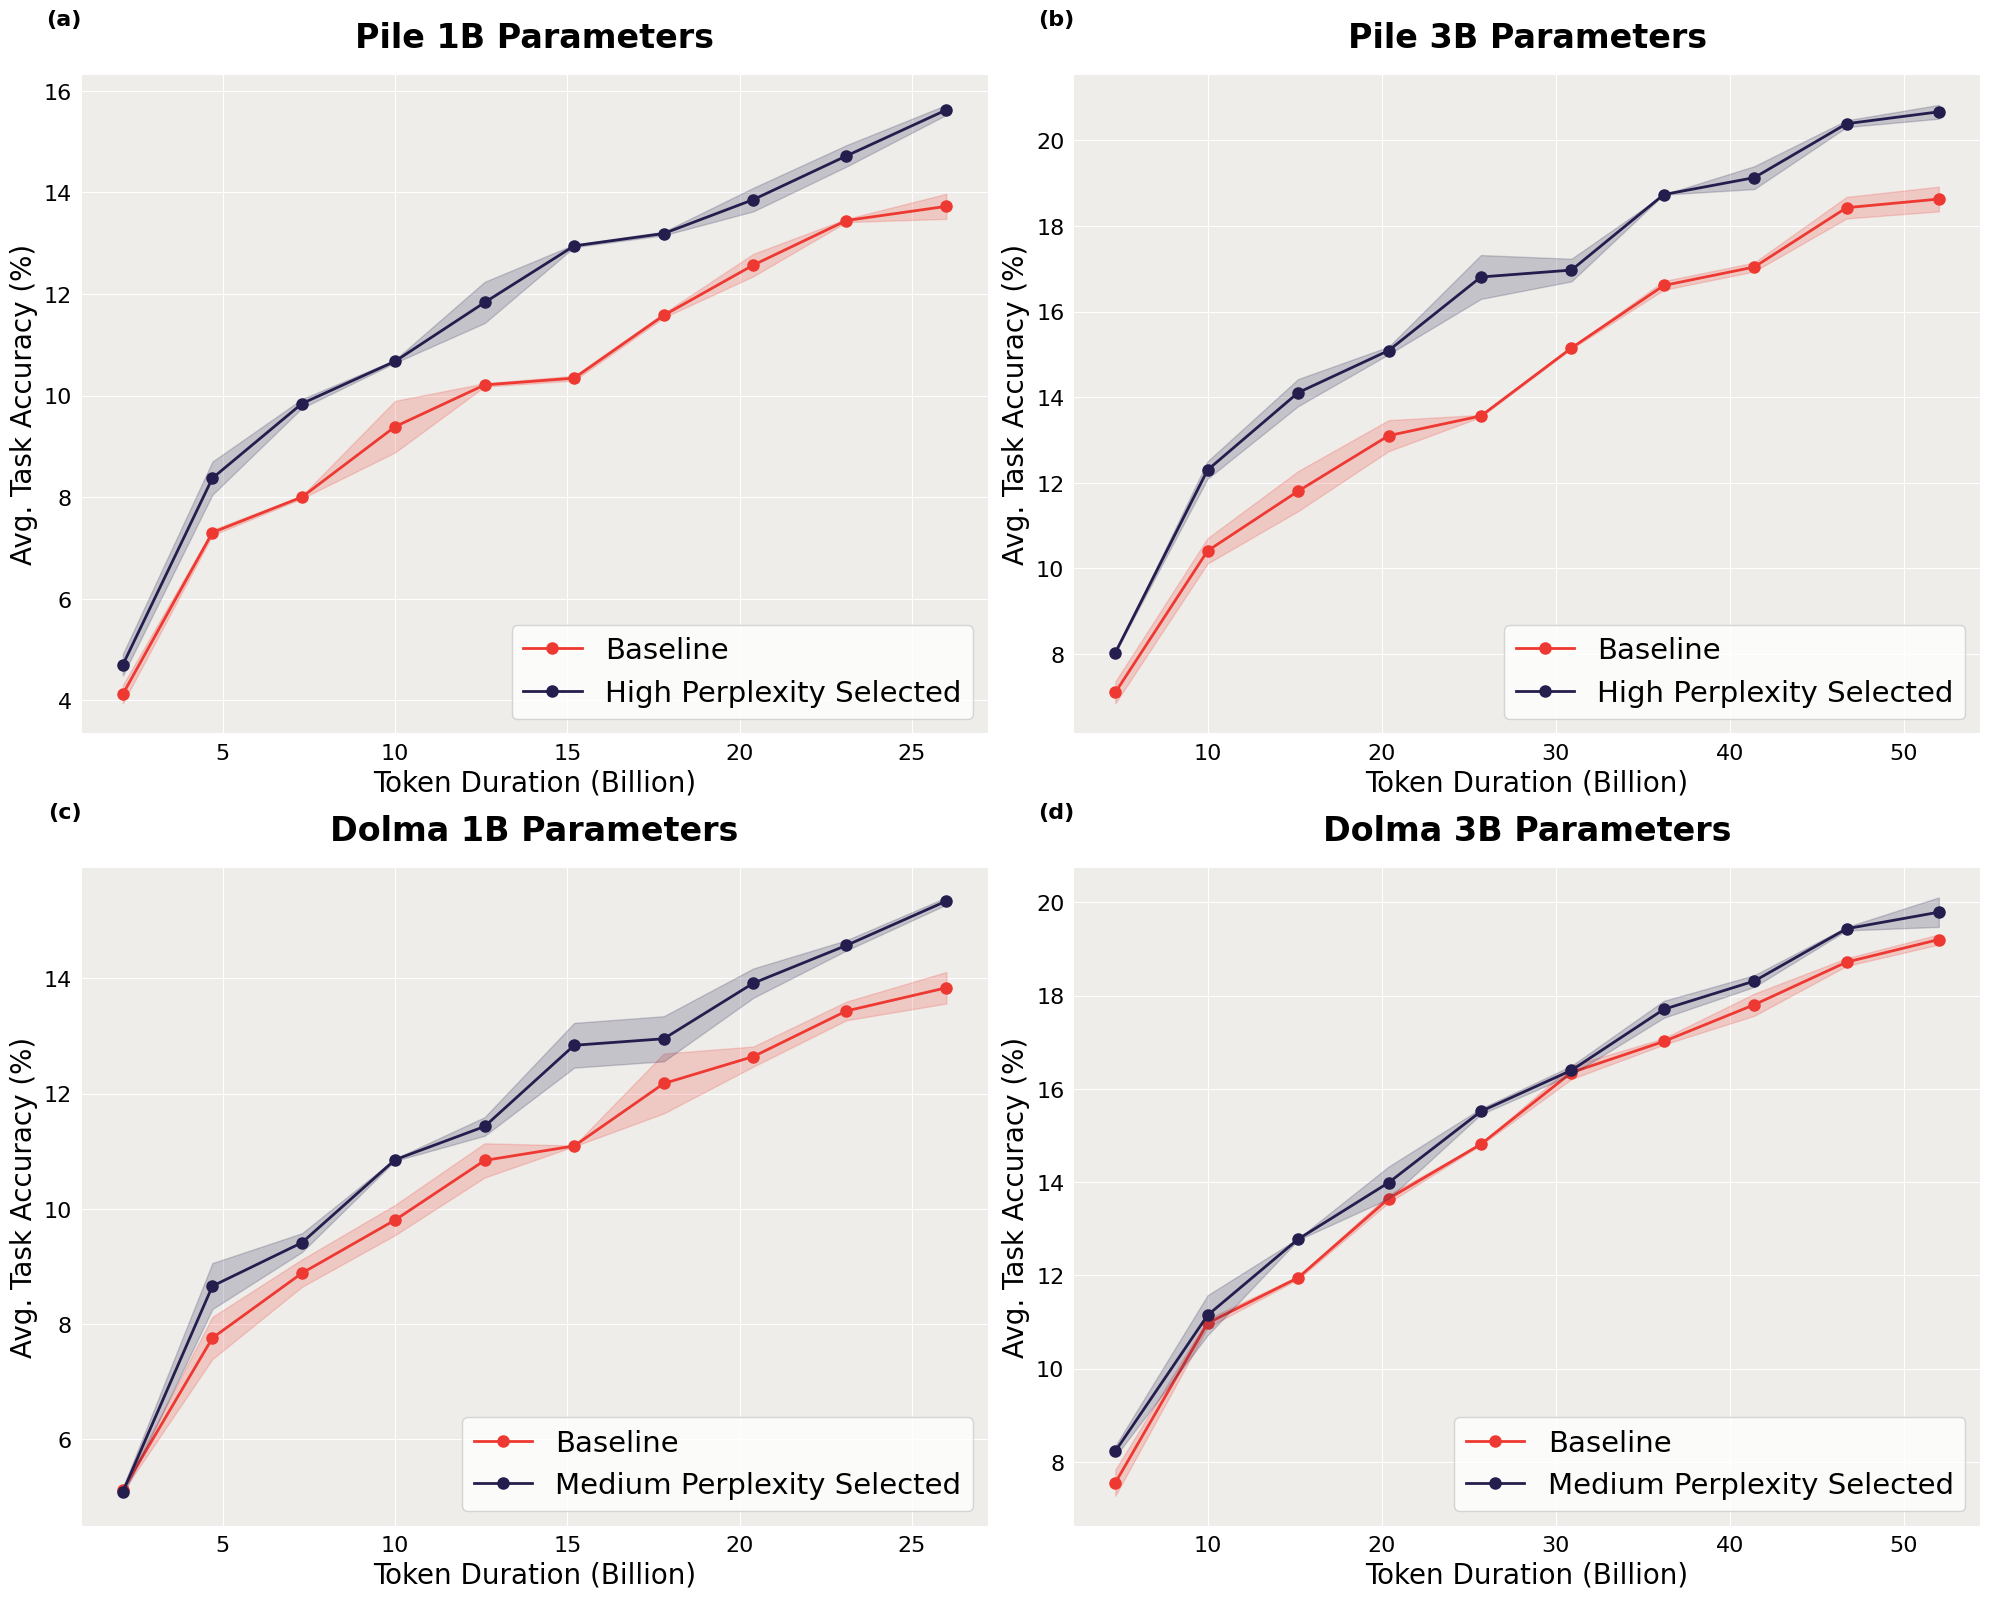

In [41]:
to_plot = [
    {
        "title": "Pile 1B Parameters",
        "results": [
            {
                "run_name": "Baseline",
                "step_metrics": pile_1b_processed_results["pile-passes-0.25-final-1B-26B-baseline"]
            },
            {
                "run_name": "High Perplexity Selected",
                "step_metrics": pile_1b_processed_results["pile-passes-0.25-final-1B-26B-offline-global-hard-0.5-ref-125M-26B"]
            },
        ],
    },
    {
        "title": "Pile 3B Parameters",
        "results": [
            {
                "run_name": "Baseline",
                "step_metrics": pile_3b_processed_results["pile-passes-0.5-final-3B-52B-baseline"]
            },
            {
                "run_name": "High Perplexity Selected",
                "step_metrics": pile_3b_processed_results["pile-passes-0.5-final-3B-52B-offline-global-hard-0.5-ref-125M-26B"]
            },
        ],
    },
    {
        "title": "Dolma 1B Parameters",
        "results": [
            {
                "run_name": "Baseline",
                "step_metrics": dolma_1b_processed_results["dolma-passes-0.25-final-1B-26B-baseline"]
            },
            {
                "run_name": "Medium Perplexity Selected",
                "step_metrics": dolma_1b_processed_results["dolma-passes-0.25-final-1B-26B-offline-global-mid-0.5-ref-125M-26B"]
            },
        ],
    },
    {
        "title": "Dolma 3B Parameters",
        "results": [
            {
                "run_name": "Baseline",
                "step_metrics": dolma_3b_processed_results["dolma-passes-0.5-final-3B-52B-baseline"]
            },
            {
                "run_name": "Medium Perplexity Selected",
                "step_metrics": dolma_3b_processed_results["dolma-passes-0.5-final-3B-52B-offline-global-mid-0.5-ref-125M-26B"]
            },
        ],
    },
    # {
    #     "title": "WDD 1B Parameters",
    #     "results": [
    #         {
    #             "run_name": "Baseline",
    #             "step_metrics": mpt_1b_processed_results["mpt-passes-0.25-final-1B-26B-baseline"]
    #         },
    #         {
    #             "run_name": "Medium Perplexity Selected",
    #             "step_metrics": mpt_1b_processed_results["mpt-passes-0.25-final-1B-26B-offline-global-mid-0.5-ref-125M-26B"]
    #         },
    #     ],
    # },
    # {
    #     "title": "WDD 3B Parameters",
    #     "results": [
    #         {
    #             "run_name": "Baseline",
    #             "step_metrics": mpt_3b_processed_results["mpt-passes-0.5-final-3B-52B-baseline"]
    #         },
    #         {
    #             "run_name": "Medium Perplexity Selected",
    #             "step_metrics": mpt_3b_processed_results["mpt-passes-0.5-final-3B-52B-offline-global-mid-0.5-ref-125M-26B"]
    #         },
    #     ],
    # },
]
plot_paper_results(to_plot, "figs/pareto.pdf")

In [42]:
def compute_speedup(baseline_results, filtered_results, max_step, raw=False):
    key = "raw_metrics" if raw else "normalized_metrics"
    target_acc = baseline_results[max_step][key]["avgs"][-1]
    steps = sorted(filtered_results.keys())
    avgs = [filtered_results[step][key]["avgs"][-1] for step in steps]
    filtered_inv_fn = interp1d(avgs, steps)
    achieve_step = filtered_inv_fn(target_acc)
    print(f"Step achived: ", achieve_step)
    print(f"Sppedup: ", max_step / achieve_step)


In [43]:
print("Pile 1B")
compute_speedup(pile_1b_processed_results["pile-passes-0.25-final-1B-26B-baseline"], pile_1b_processed_results["pile-passes-0.25-final-1B-26B-offline-global-hard-0.5-ref-125M-26B"], 26.0)
print("=" * 20)
print("Pile 3B")
compute_speedup(pile_3b_processed_results["pile-passes-0.5-final-3B-52B-baseline"], pile_3b_processed_results["pile-passes-0.5-final-3B-52B-offline-global-hard-0.5-ref-125M-26B"], 52.0)
print("=" * 20)
print("MPT 1B")
compute_speedup(mpt_1b_processed_results["mpt-passes-0.25-final-1B-26B-baseline"], mpt_1b_processed_results["mpt-passes-0.25-final-1B-26B-offline-global-mid-0.5-ref-125M-26B"], 26.0)
print("=" * 20)
print("MPT 3B")
compute_speedup(mpt_3b_processed_results["mpt-passes-0.5-final-3B-52B-baseline"], mpt_3b_processed_results["mpt-passes-0.5-final-3B-52B-offline-global-mid-0.5-ref-125M-26B"], 52.0)
print("=" * 20)
print("Dolma 1B")
compute_speedup(dolma_1b_processed_results["dolma-passes-0.25-final-1B-26B-baseline"], dolma_1b_processed_results["dolma-passes-0.25-final-1B-26B-offline-global-mid-0.5-ref-125M-26B"], 26.0)
print("=" * 20)
print("Dolma 3B")
compute_speedup(dolma_3b_processed_results["dolma-passes-0.5-final-3B-52B-baseline"], dolma_3b_processed_results["dolma-passes-0.5-final-3B-52B-offline-global-mid-0.5-ref-125M-26B"], 52.0)

Pile 1B
Step achived:  19.881825981446873
Sppedup:  1.3077269675462617
Pile 3B
Step achived:  35.88467249150727
Sppedup:  1.4490866542618357
MPT 1B
Step achived:  19.317568175267258
Sppedup:  1.3459251063127302
MPT 3B
Step achived:  45.380720736408115
Sppedup:  1.1458610431077036
Dolma 1B
Step achived:  20.182823267382666
Sppedup:  1.288224132746504
Dolma 3B
Step achived:  45.607443827967664
Sppedup:  1.1401647545989468


In [52]:
colors = [
    "#EE3932",
    "#241E4E",
]
background = "#EEEDE9"
subplot_labels = ["(a)", "(b)", "(c)", "(d)"]

def plot_repeat_results(groups, step, save_name="", repeats=["0.5", "1.0", "2.0", "4.0", "8.0"], raw=False):
    num_groups = len(groups)
    cols = 4
    rows = math.ceil(num_groups / 2)

    fig = plt.figure(figsize=(20, 6*rows))
    gs = gridspec.GridSpec(rows, cols, figure=fig)

    for i, group in enumerate(groups):
        # For the last plot in an odd number of groups, center it in the last row.
        if i == num_groups - 1 and num_groups % 2 != 0:
            ax = fig.add_subplot(gs[-1, 1:3])
        else:
            ax = fig.add_subplot(gs[i // cols, 2*(i % cols) : 2*(i % cols + 1)])
    
        title = group["title"]
        group_results = group["results"]

        # Iterate over each run
        max_avg = 0
        for result_idx, result_set in enumerate(group_results):
            run_name = result_set["run_name"]

            # Get the metric values for the current category
            key = "raw_metrics" if raw else "normalized_metrics"
            avg_metrics = [step_metric[step][key]["avgs"][-1] * 100 for step_metric in result_set["step_metrics"]]
            ste_metrics = [step_metric[step][key]["stes"][-1] * 100 for step_metric in result_set["step_metrics"]]
            if run_name == "Medium Perplexity Selected" and "WDD" in title:
                print(ste_metrics)
                
            max_avg = max(max_avg, max(avg_metrics))
        
            ax.plot(list(range(len(repeats))), avg_metrics, label=run_name, color=colors[result_idx], marker="o", zorder=2, linewidth=2, markersize=8)
            ax.fill_between(list(range(len(repeats))), np.array(avg_metrics) - np.array(ste_metrics), np.array(avg_metrics) + np.array(ste_metrics), color=colors[result_idx], alpha=0.2, zorder=2)
        
        
        ax.legend(loc="upper right", frameon=True, fontsize=21)

        # Label information
        ax.set_ylabel("Avg. Task Accuracy (%)", fontsize=20)
        ax.set_xlabel("Repeats", fontsize=20)
        ax.set_xticks(ticks=list(range(len(repeats))), labels=repeats)
        ax.set_title(title, fontsize=24, fontweight="bold", pad=20)

        # Add space for legend
        # ax.set_ylim(None, 1.2*max_avg)
        ax.set_ylim(29, 36)

        # Change background color
        ax.set_facecolor(background) 
        ax.grid(True, color='white', zorder=1)

        # Remove the borders from the graph
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)

        # Format the ticks
        ax.tick_params(axis='both', which='both', bottom=False, left=False, top=False, right=False, labelsize=16)

        ax.set_facecolor(background)
        # Label subplot
        ax.text(0, 1.1, subplot_labels[i], transform=ax.transAxes, fontsize=16, fontweight='bold', va='top', ha='right')

    # # Remove any unused subplots
    # for i in range(len(metric_names), len(axs)):
    #     fig.delaxes(axs[i])

    plt.tight_layout()

    # Save the figure to disk
    if save_name:
        plt.savefig(save_name)

    plt.show()

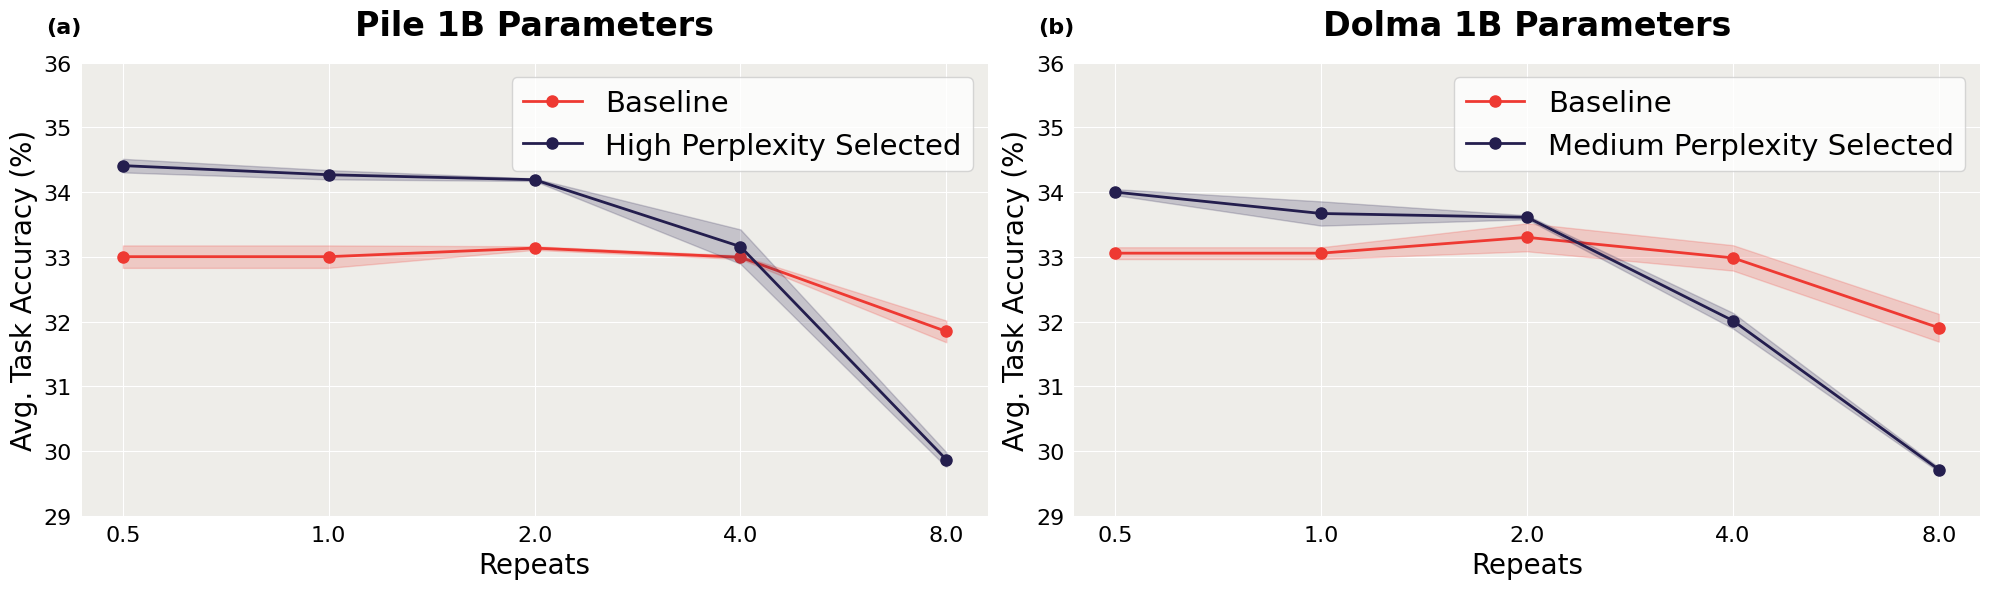

In [53]:
to_plot = [
    {
        "title": "Pile 1B Parameters",
        "results": [
            {
                "run_name": "Baseline",
                "step_metrics": [
                    pile_repeats_processed_results["pile-passes-0.25-final-1B-26B-baseline"],
                    pile_repeats_processed_results["pile-passes-0.25-final-1B-26B-baseline"],
                    pile_repeats_processed_results["pile-passes-2.0-final-1B-26B-baseline"],
                    pile_repeats_processed_results["pile-passes-4.0-final-1B-26B-baseline"],
                    pile_repeats_processed_results["pile-passes-8.0-final-1B-26B-baseline"],
                ]
            },
            {
                "run_name": "High Perplexity Selected",
                "step_metrics": [
                    pile_repeats_processed_results["pile-passes-0.25-final-1B-26B-offline-global-hard-0.5-ref-125M-26B"],
                    pile_repeats_processed_results["pile-passes-1.0-final-1B-26B-offline-global-hard-0.5-ref-125M-26B"],
                    pile_repeats_processed_results["pile-passes-2.0-final-1B-26B-offline-global-hard-0.5-ref-125M-26B"],
                    pile_repeats_processed_results["pile-passes-4.0-final-1B-26B-offline-global-hard-0.5-ref-125M-26B"],
                    pile_repeats_processed_results["pile-passes-8.0-final-1B-26B-offline-global-hard-0.5-ref-125M-26B"],
                ]
            },
        ],
    },
    {
        "title": "Dolma 1B Parameters",
        "results": [
            {
                "run_name": "Baseline",
                "step_metrics": [
                    dolma_repeats_processed_results["dolma-passes-0.25-final-1B-26B-baseline"],
                    dolma_repeats_processed_results["dolma-passes-0.25-final-1B-26B-baseline"],
                    dolma_repeats_processed_results["dolma-passes-2.0-final-1B-26B-baseline"],
                    dolma_repeats_processed_results["dolma-passes-4.0-final-1B-26B-baseline"],
                    dolma_repeats_processed_results["dolma-passes-8.0-final-1B-26B-baseline"],
                ]
            },
            {
                "run_name": "Medium Perplexity Selected",
                "step_metrics": [
                    dolma_repeats_processed_results["dolma-passes-0.25-final-1B-26B-offline-global-mid-0.5-ref-125M-26B"],
                    dolma_repeats_processed_results["dolma-passes-1.0-final-1B-26B-offline-global-mid-0.5-ref-125M-26B"],
                    dolma_repeats_processed_results["dolma-passes-2.0-final-1B-26B-offline-global-mid-0.5-ref-125M-26B"],
                    dolma_repeats_processed_results["dolma-passes-4.0-final-1B-26B-offline-global-mid-0.5-ref-125M-26B"],
                    dolma_repeats_processed_results["dolma-passes-8.0-final-1B-26B-offline-global-mid-0.5-ref-125M-26B"],
                ]
            },
        ],
    },
    # {
    #     "title": "WDD 1B Parameters",
    #     "results": [
    #         {
    #             "run_name": "Baseline",
    #             "step_metrics": [
    #                 mpt_repeats_processed_results["mpt-passes-0.25-final-1B-26B-baseline"],
    #                 mpt_repeats_processed_results["mpt-passes-0.25-final-1B-26B-baseline"],
    #                 mpt_repeats_processed_results["mpt-passes-2.0-final-1B-26B-baseline"],
    #                 mpt_repeats_processed_results["mpt-passes-4.0-final-1B-26B-baseline"],
    #                 mpt_repeats_processed_results["mpt-passes-8.0-final-1B-26B-baseline"],
    #             ]
    #         },
    #         {
    #             "run_name": "Medium Perplexity Selected",
    #             "step_metrics": [
    #                 mpt_repeats_processed_results["mpt-passes-0.25-final-1B-26B-offline-global-mid-0.5-ref-125M-26B"],
    #                 mpt_repeats_processed_results["mpt-passes-1.0-final-1B-26B-offline-global-mid-0.5-ref-125M-26B"],
    #                 mpt_repeats_processed_results["mpt-passes-2.0-final-1B-26B-offline-global-mid-0.5-ref-125M-26B"],
    #                 mpt_repeats_processed_results["mpt-passes-4.0-final-1B-26B-offline-global-mid-0.5-ref-125M-26B"],
    #                 mpt_repeats_processed_results["mpt-passes-8.0-final-1B-26B-offline-global-mid-0.5-ref-125M-26B"],
    #             ]
    #         },
    #     ],
    # },
]
# plot_paper_results(to_plot, "figs/repeats.pdf")
plot_repeat_results(to_plot, step=26.0, raw=True, save_name="figs/repeats.pdf")

In [48]:
mpt_repeats_processed_results["mpt-passes-4.0-final-1B-26B-offline-global-mid-0.5-ref-125M-26B"]

defaultdict(dict,
            {26.0: {'raw_metrics': {'avgs': array([0.28865652, 0.49992877, 0.56172287, 0.08690464, 0.28554959,
                      0.34455248]),
               'stes': array([0.00371212, 0.00322209, 0.00035952, 0.00251111, 0.00153866,
                      0.00022059]),
               'n_res': 2},
              'normalized_metrics': {'avgs': array([0.18261702, 0.13668418, 0.33750846, 0.03694006, 0.07954046,
                      0.15465804]),
               'stes': array([0.00412975, 0.00587465, 0.00068698, 0.00262625, 0.00354041,
                      0.00066921]),
               'n_res': 2}}})